# Project overview
This notebook presents the core concepts developed during my thesis. The goal is to provide a high-level overview of the project and to explain the main ideas behind the code. The code itself is available in the `src` folder.

## Problem statement
The main goal of this project is to develop a method to solve the `path-planning` problem by taking inspiration on chemotaxis and the way bacteria move in their environment. The problem is defined as follows: given a starting configuration a goal configuration, find a path that connects the two configuration without intersecting any obstacle. The path should be as short as possible and should be found in a reasonable amount of time.

Furthermore, we want our method to have the following properties :
- to sample different paths from a given configuration
- to be able to cut through an obstacle if necessary
- to adapt to dynamic environments

This properties are required for the final application wich is surgical planning. In this context, the surgeon needs to be able to explore different paths from a given configuration with a quality mesure associated to it. Furthermore, the device should be able to make its way through an obstacle, as a bone or a muscle, if necessary. Finally, the method should handle incertainty on the obstacle positions since the surgeon can move obstacles during the surgery.

<img src="figures/cochlea.jpg" width=400 height=200 />
<figcaption>Figure 1 : From left to right, (a) an anatomical view of a cochlea with vestibular chamber and canals, (b) a cochlear implent with the array of electrodes (wire) and the digital signal processor (white box)</figcaption>

Our case study is the cochlear implent represented in Figure 1 (b) in which an array of electrodes is bring inside the cochlea (a) to stimulate the cochlear nerve. Therefore, we consider that our path-planning problem can be reduced to finding a collision-free path for the wire containing the electrodes inside a patient head. Furthermore, we consider that the wire can be approximated by a sequence of segments that apply a constraint on the head and that only the displacement of the head is of interest. Therefore, the model we use is a point robot moving in a 3D environment and containes 6 degree of freedom.

## Chemotaxis
Chemotaxis is the movement, observed in a wide range of organisms, indiced in response to a chemical stimulus. The stimulus can be either attractive or repulsive. We will only focus on the attractive case, in which the chemical stimulus is named chemoattractant. 

It is well known that bacteria use chemotaxis to find food (cf. Figure 2). The idea is that bacteria use the gradient of a chemoattractant to be guided toward the food. The gradient of the chemoattractant is computed by the bacteria and is used to control the direction of the movement. The movement is then a combination of a random walk and a directed movement. The random walk is used to explore the environment and the directed movement is used to move toward the food. The random walk is often  modeled by a Brownian motion and the directed movement is modeled by a drift term. The drift term is proportional to the gradient of the chemoattractant. The model is given by the following stochastic differential equation : 
$$dX_t = \sigma dB_t + \mu dt$$
where $X_t$ is the position of the bacteria at time $t$, $\sigma$ is the diffusion coefficient, $B_t$ is a Brownian motion and $\mu$ is the drift term. 

<img src="figures/E.colis.gif" class="center" width=400 height=200 />
<figcaption>Figure 2 : <i>E.Colis</i> bacteria moving toward a chemoattractant located in the left part of the screen.</figcaption> 

For the drift term not to be dependent of the local variation of concentration, it is shown that it can be described by :
$$\mu = \nabla \log C = \frac{\nabla C}{C}$$
where $C$ is the concentration of the chemoattractant. 

Finaly, we can estimate concentration of the chemoattractant at time $t$ by solving the heat equation : 
$$\partial_t C = D\Delta C$$
where $D$ is the diffusion coefficient of the process.

## Concentration field navigation
Using analogie with the chemotaxis study, the robot can be modeled as the organism and the chemical stimulus is the gradient of a scalar field based on the concentration distribution in the environment. The idea is to use the gradient of a scalar field to guide the robot toward a goal configuration. The scalar field is computed by solving the heat equation with a source term at the goal configuration and absorbing boundary condition on obstacles. The source term is a Dirac delta function and servesn as a source for the chemoatractant. The model is given by the following system of differential equation : 

$$\begin{cases} 
\partial_t C = D\Delta C + C_0\delta_{x_0} \\
C(x, 0) = C_0\delta_{x_0} \space \forall x \in \Omega \\
C(x, t) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$

In order to simplify the problem and to reduce the computational cost, we consider that the scalar field is constant in time (stationarity). Therefore, we can solve the following elliptic equation system instead of the previous one :
$$\begin{cases} 
- \Delta C = \frac{C_0}{D} \delta_{x_0} \\
C(x, 0) = C_0\delta_{x_0} \space \forall x \in \Omega \\
C(x, t) = 0 \space \forall x \in \partial \Omega 
\end{cases}$$

## Python implementation
For a detailed introduction to the code, please refer to the `README.md` file in the `src` folder. The code is divided in 3 main parts :
- `envs` : contains the code for the creation of environements as subclass of gym.Env. It includes 2D and 3D environements with respectively random obstacles, maze, slots and obstacle-free environement.
- `taichi / phiflow` : contains the code for the numerical solver of the differential equations and the simulation of chemotactic walks with specialized libraries `taichi` or `phiflow`.
- `utils` : contains the code for the visualization of the scalar field and the path sampling.

In [1]:
%matplotlib inline
# Project imports
from snake_ai.envs import RandomObstaclesEnv, RoomEscape, SlotEnv, RandomObstacles3D, EnvConverter, Env3DConverter
from snake_ai.diffsim import DiffusionSolver, WalkerSimulationStoch2D, WalkerSimulationStoch3D
from snake_ai.diffsim.field import log, spatial_gradient
from snake_ai.utils.visualization import Visualizer
import snake_ai.utils.visualization as vis

# External imports
import tqdm
import taichi as ti
import taichi.math as tm
import numpy as np
import matplotlib.pyplot as plt

pygame 2.4.0 (SDL 2.26.5, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.11


[I 05/02/24 18:06:59.828 12703] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


### 2D exemples
Let first visualize 2D environement exemples with random obstacles and maze. The goal is represented by a green dot, the starting configuration by a blue dot and obstacles as red rectangles.

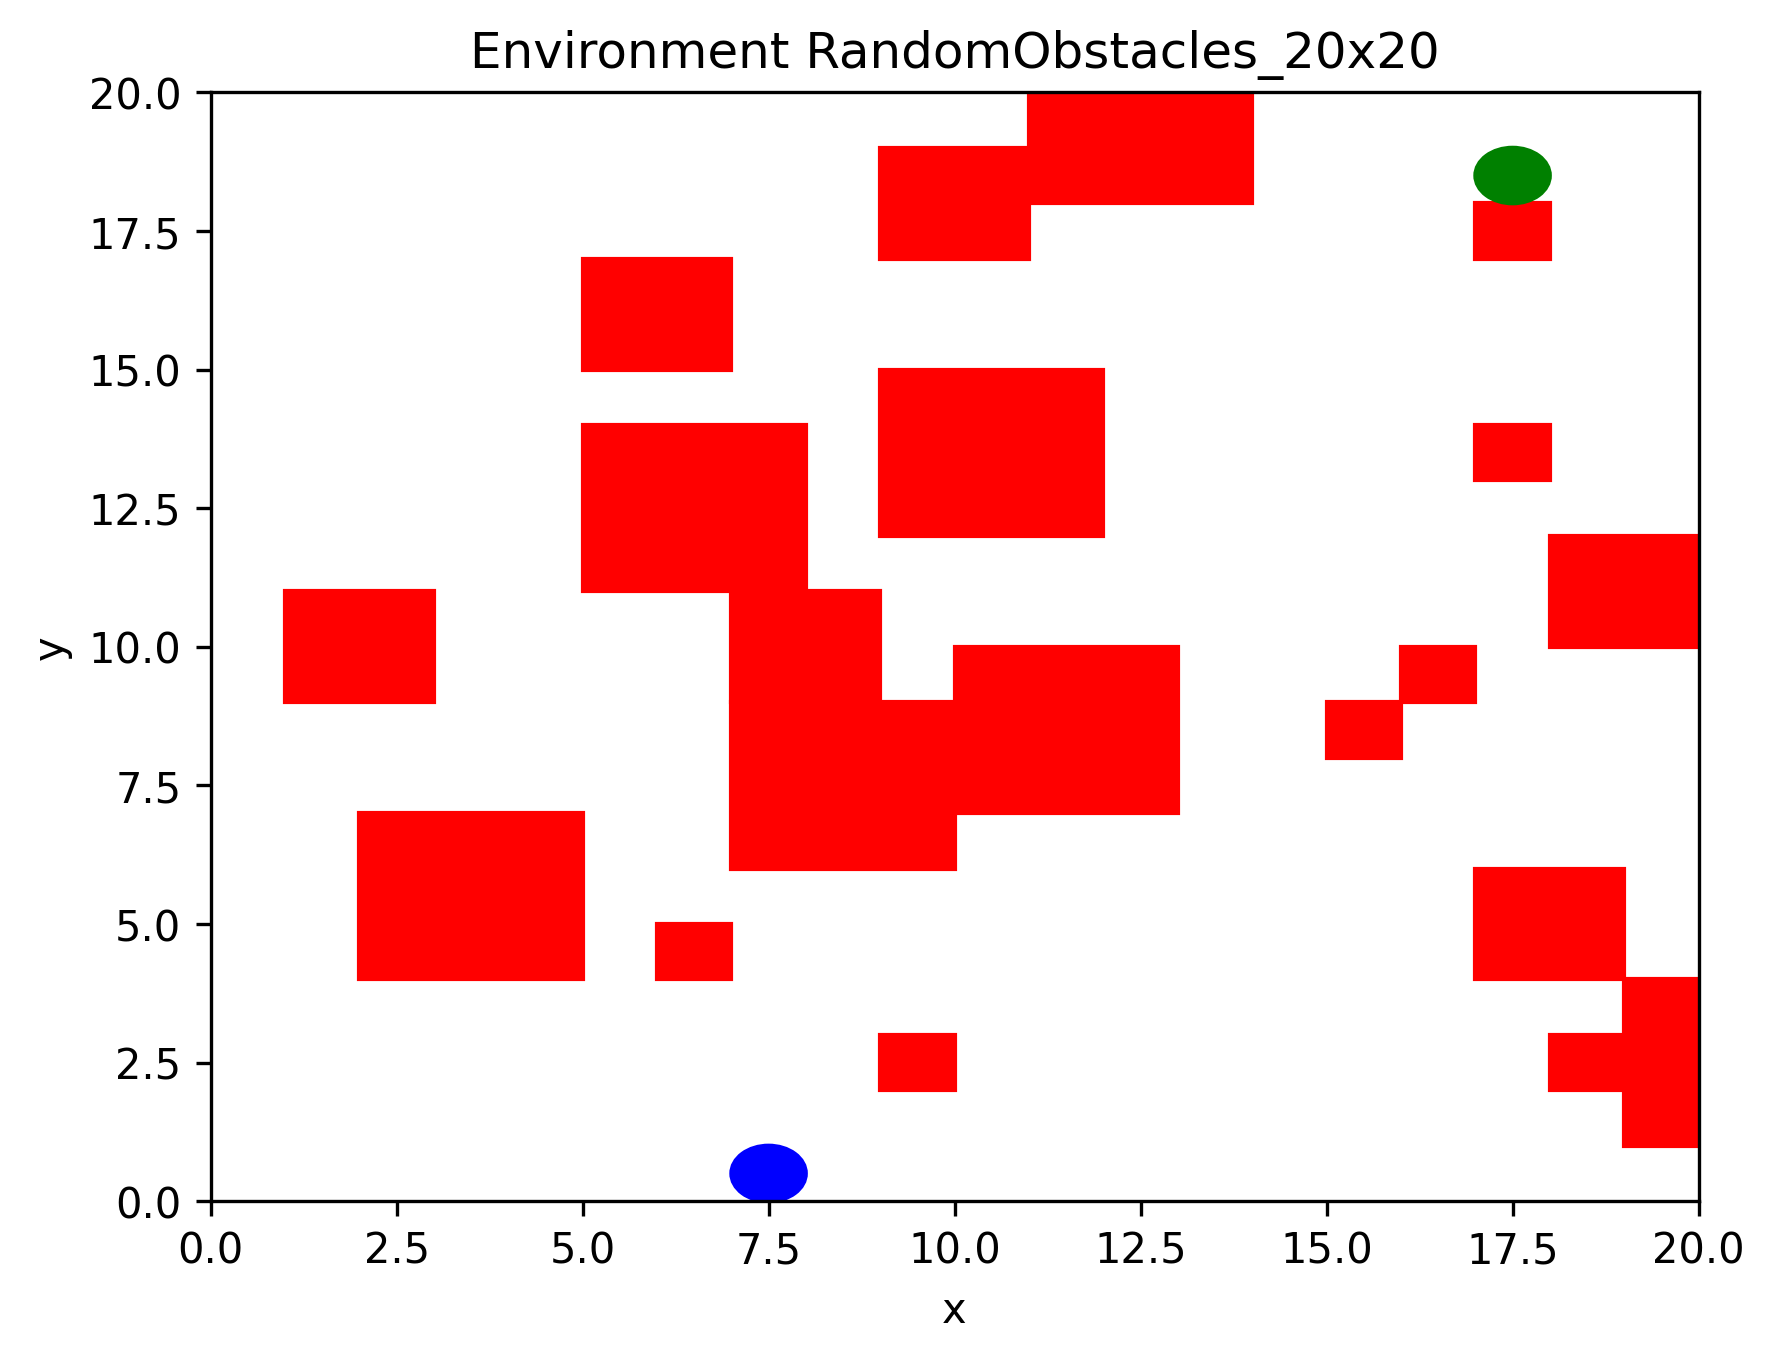

In [2]:
seed = 35
height, width = 20, 20
nb_obs, obs_size = 20, 3

env = RandomObstaclesEnv(height, width, pixel=1, nb_obs=nb_obs, max_obs_size=obs_size, seed=seed)
env.reset()
fig = vis.Visualizer.plot_2D_environment(env)

### Concentration estimation
We can then estimate a scalar field based on the concentration distribution in the environment as discribed in the [previous section](#concentration-field-navigation). The concentration is computed at stationarity with [Finite Difference Method](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter23.03-Finite-Difference-Method.html) by solving the inverse problem :
$$-[\Delta] C = b$$ 
where $[\Delta]$ is the discretized version of the Laplacian operator and $b$ is the source term with ones at the source position and zeros elsewhere.

[Taichi] Starting on arch=cuda


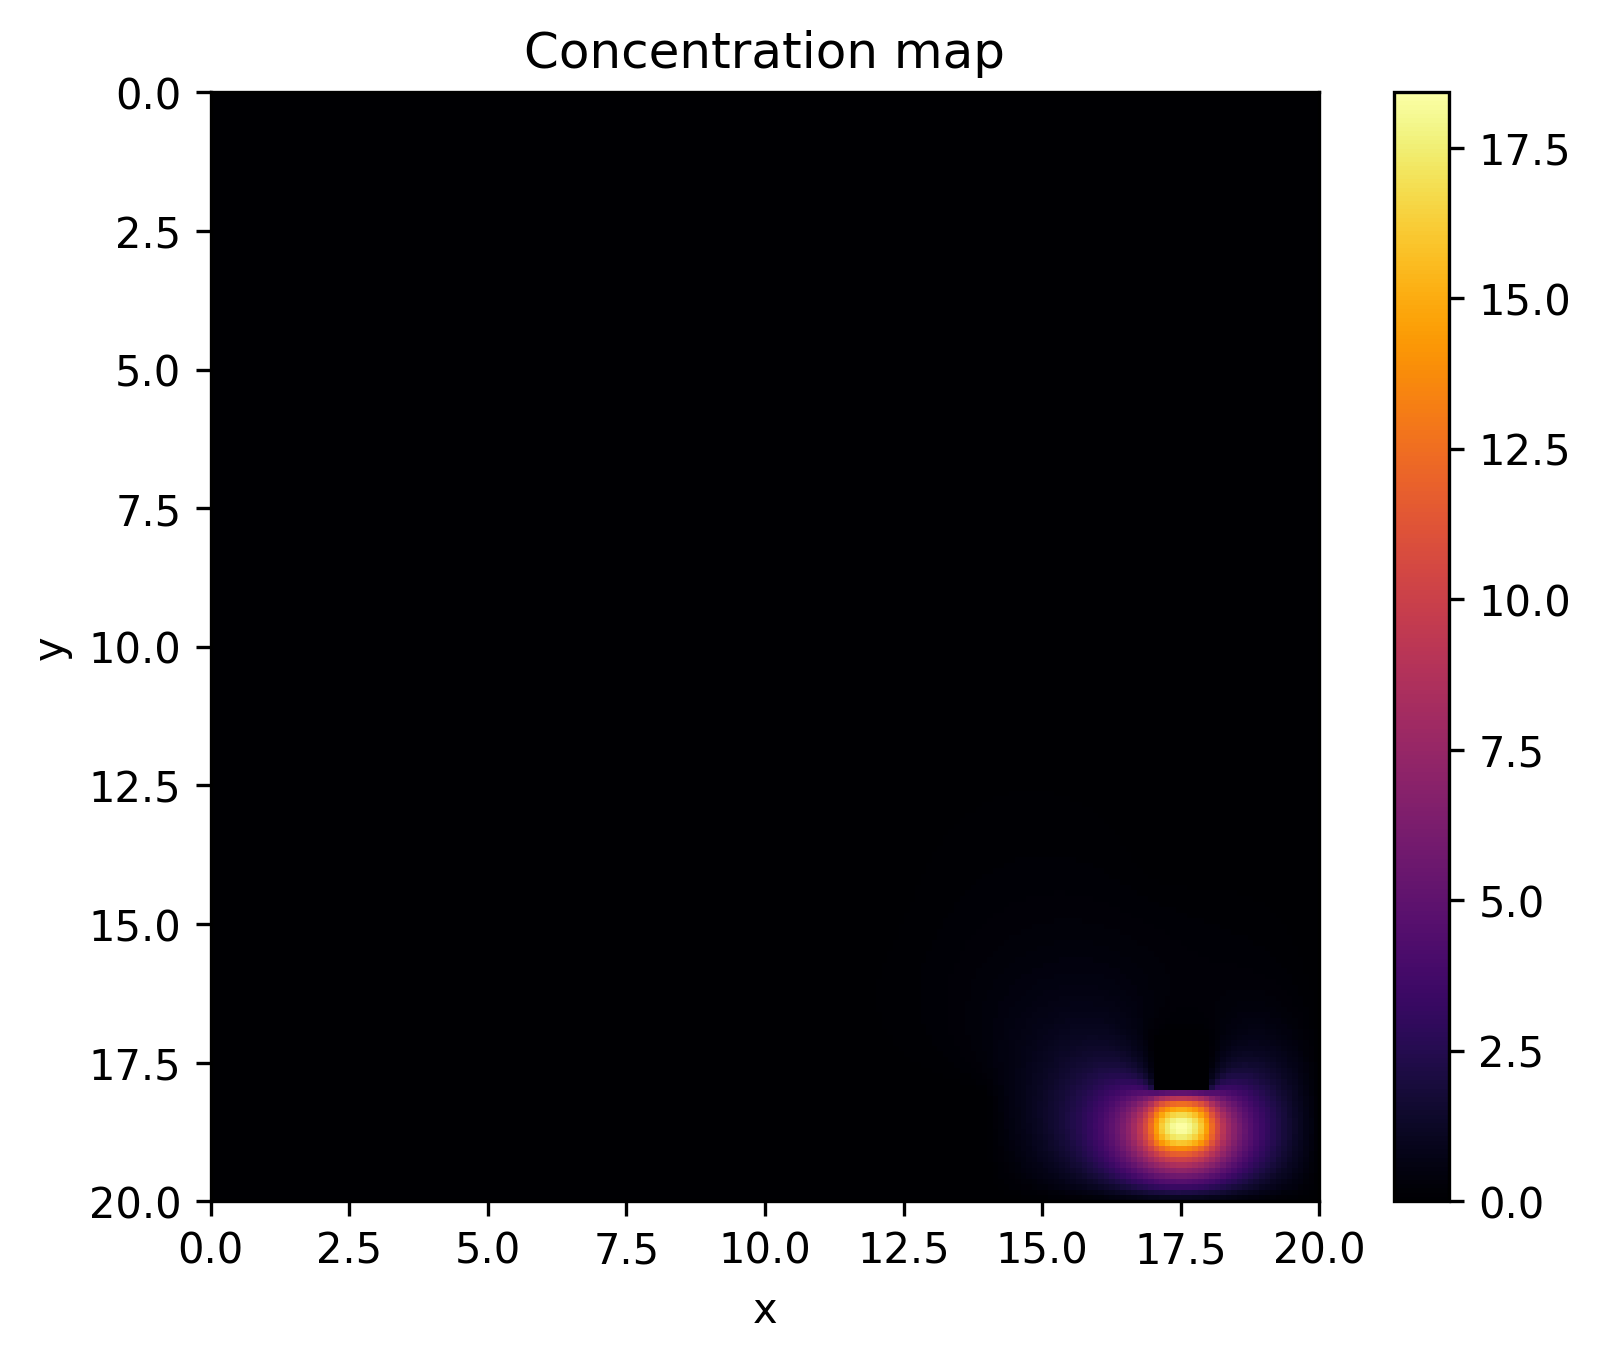

In [7]:
res = 10
ti.init(arch=ti.gpu)

solver = DiffusionSolver(env, resolution=res)
concentration = solver.solve(init_value=100)
fig = vis.Visualizer.plot_2D_field(concentration, add_quiver=False)

As we can see, the concentration decay exponentialy fast in the environment. Therefore, in order to sense variations of the concentration in the environement, it is better to use the log concentration, as observed in chemotactic agents. 

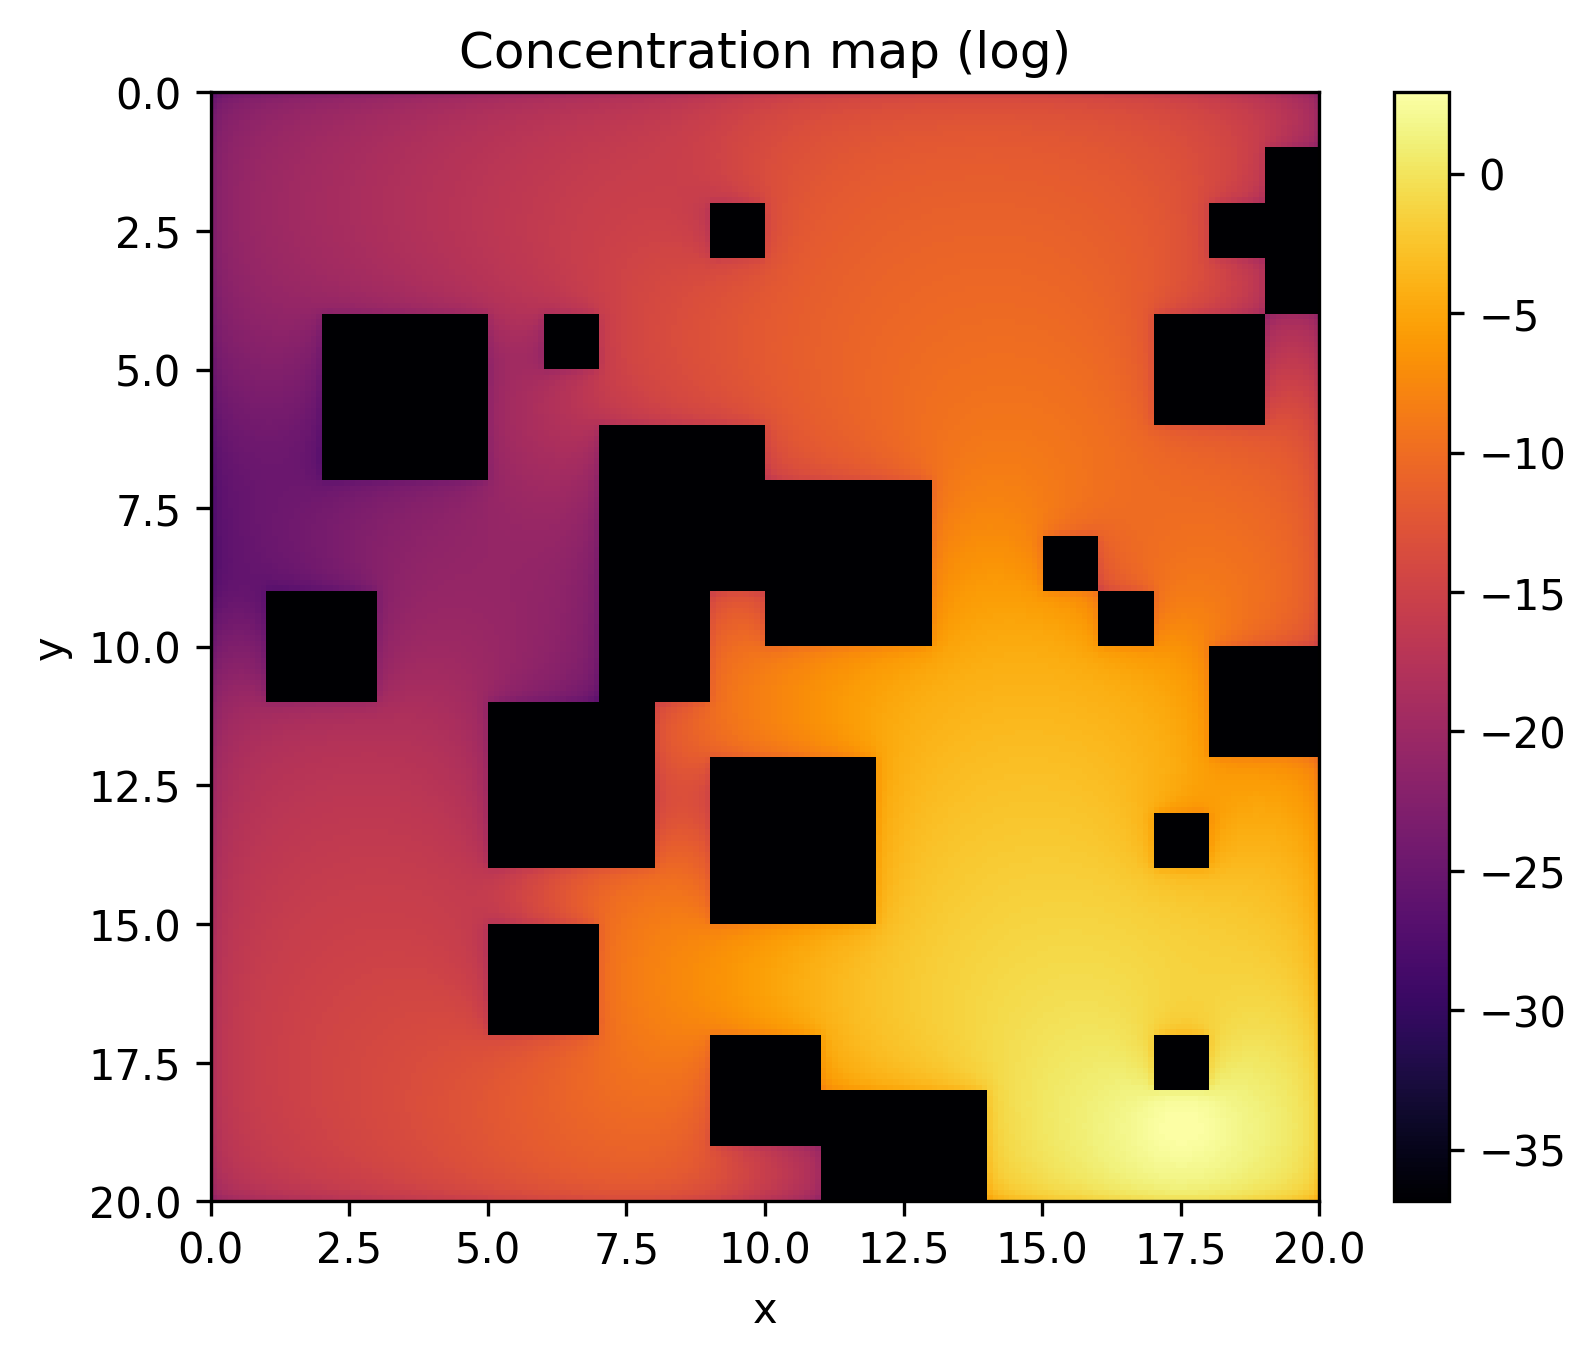

In [8]:
log_concentration = log(concentration, eps=1e-16)
fig = vis.Visualizer.plot_2D_field(log_concentration, title="Concentration map (log)", add_quiver=False)

Once the log concentration is computed, we can estimate the gradient of the scalar field by finite differences in order to define a force field that will guide the robot toward the goal configuration. 

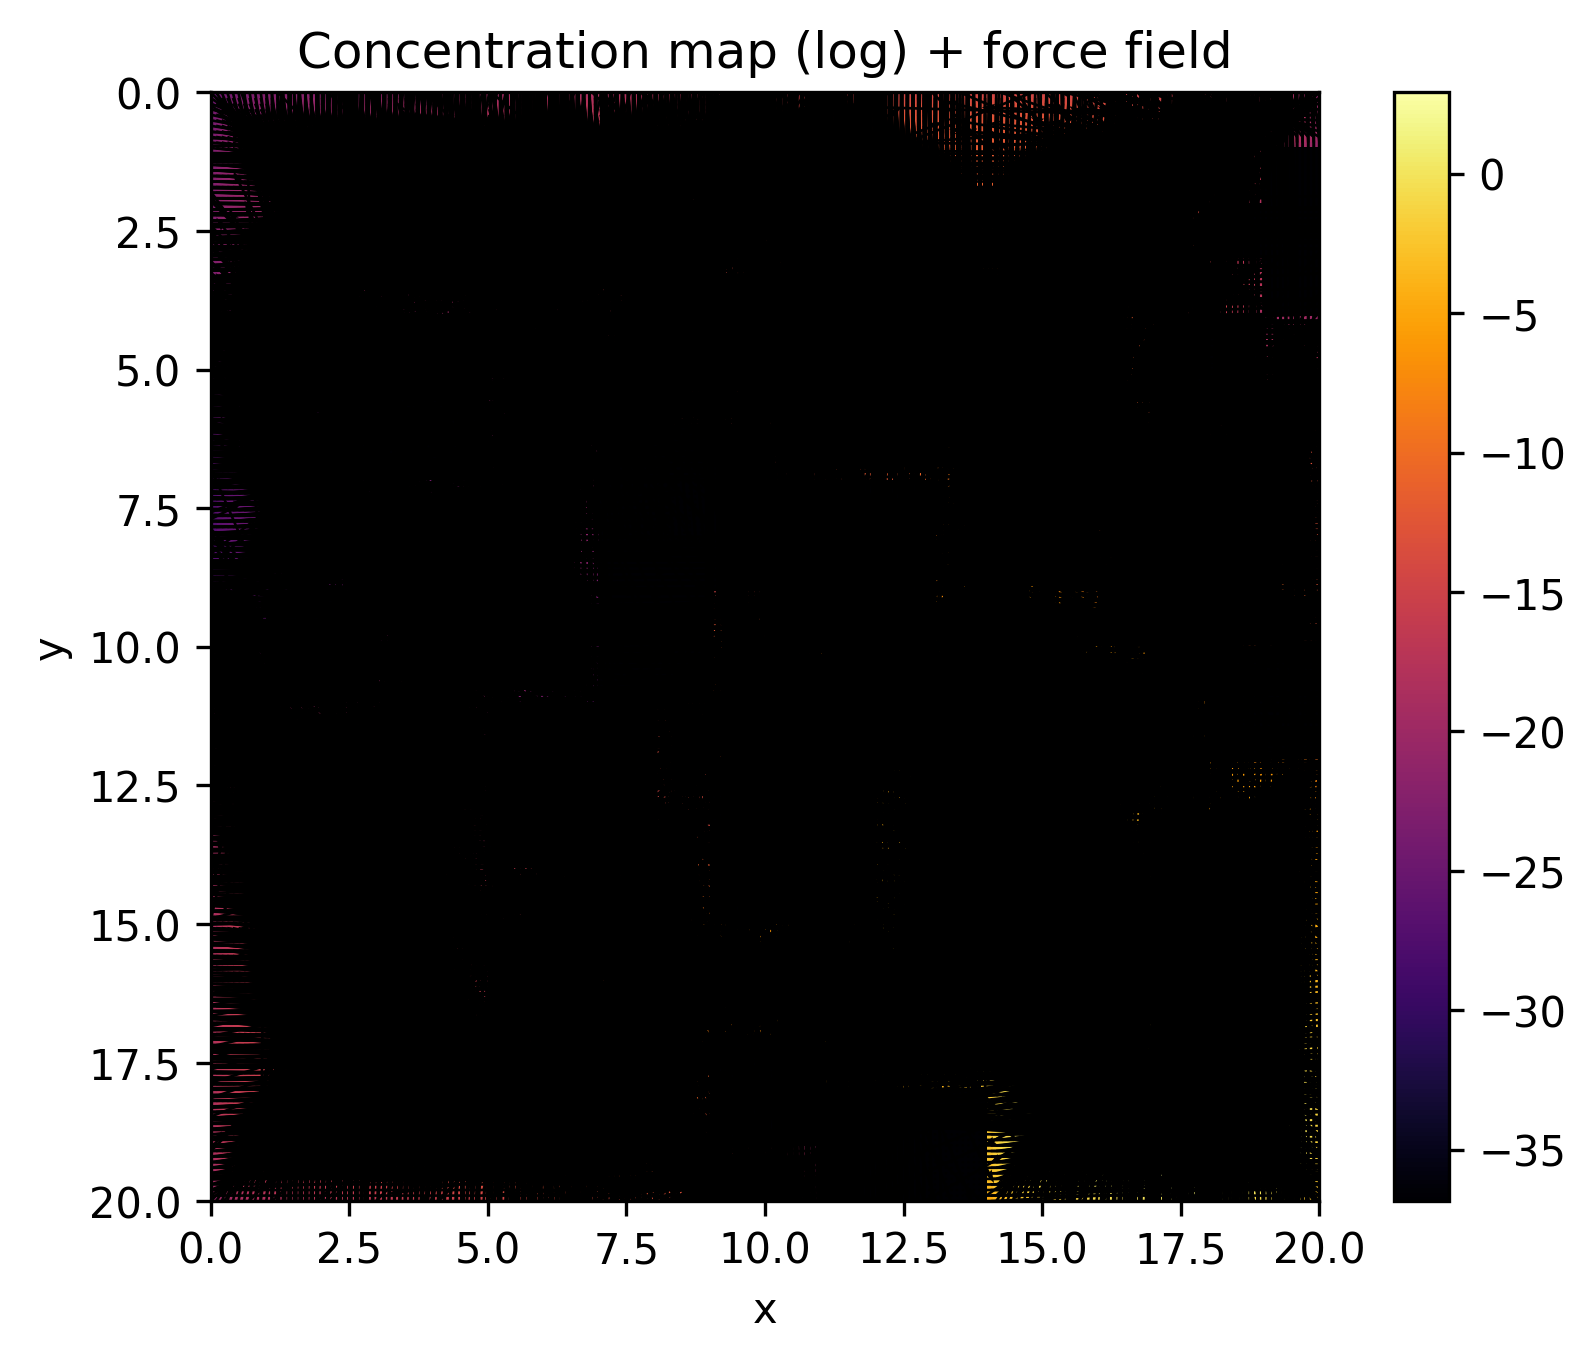

In [9]:
force_field = spatial_gradient(log_concentration)
force_field.clip(1.)
fig = vis.Visualizer.plot_2D_field(log_concentration, title="Concentration map (log) + force field", add_quiver=True)

### Path-planning with differentiable simulation
Finaly, we can solve the path-planning problem by sampling the discretised force field $F$ at each position of the agents with the following update rule : 
$$x_i^{t + 1} = x_i^t + \Delta t\nabla F(x_i^t) + \sigma \sqrt{\Delta t} \epsilon $$ 
with $\Delta t$ the time step of the simulation, $x_i^t$ the position of the *i*-th agent at time *t*, $\sigma$ the diffusion coefficient that control the chemotactic search and $\epsilon \sim \mathcal{N}(0,1)$.

To begin with we can set the diffusion coefficient to 0 in order to see what happens when agents follow a deterministic policy.

In [10]:
t_max, dt = 10, 0.1
diffusivity = 0.1
positions = np.array([[6.5, 10.5], [10.5, 10.5]])

converter = EnvConverter(env, resolution=res)
positions = converter.convert_free_positions_to_point_cloud(step=2)
simulation = WalkerSimulationStoch2D(positions, log_concentration, obstacles=env.obstacles, t_max=t_max, dt=dt)
simulation.reset()
simulation.run(diffusivity=diffusivity)

(0.0, 20.0)

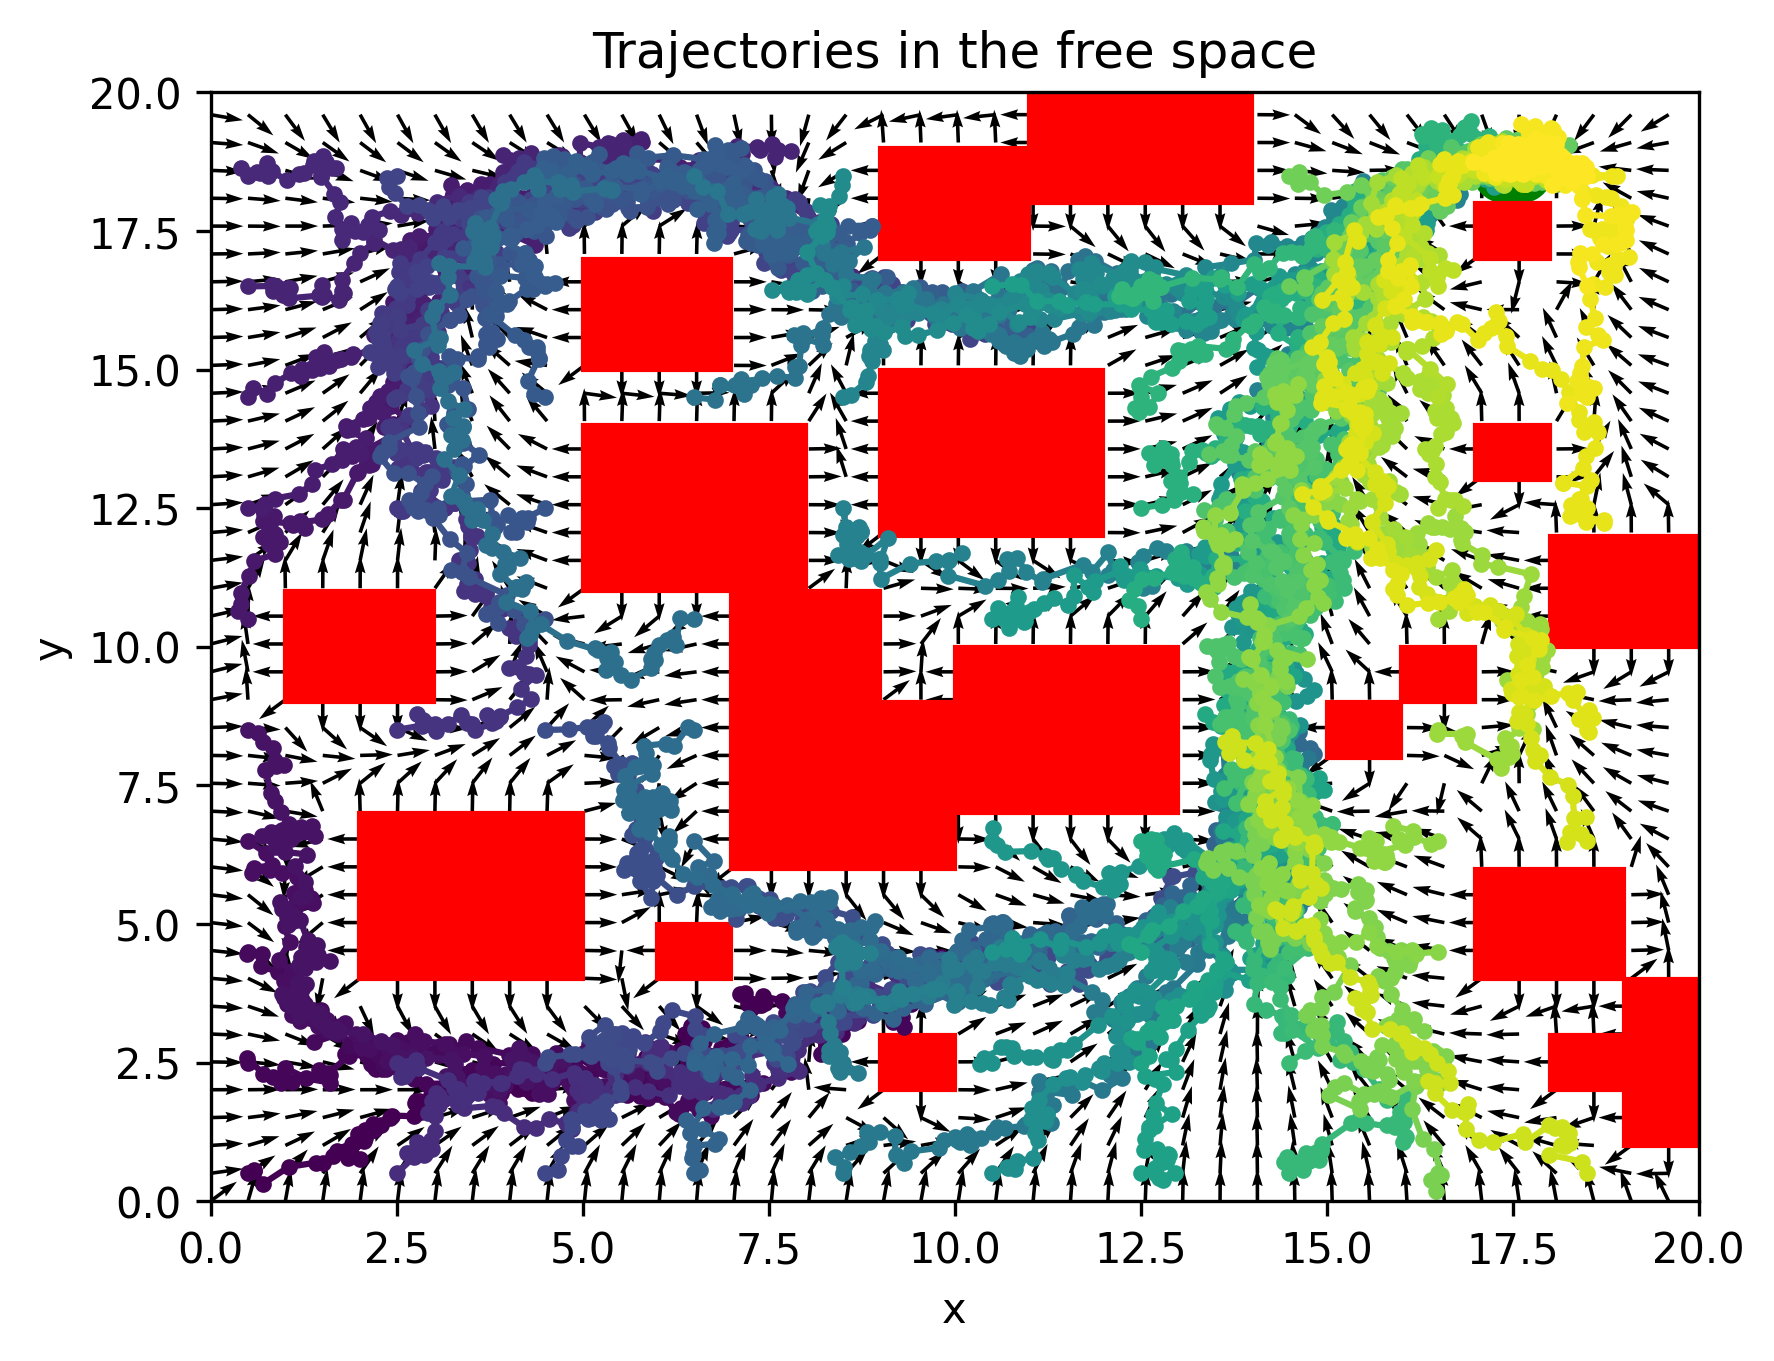

In [13]:
downscale = 5
scale = 2
# Plot the result of the simulation
goal_position = converter.get_goal_position()
fig = vis.plot_2D_trajectory(simulation.positions, goal_position, env.obstacles, vector_field=simulation.force_field, downscale=downscale, scale=scale, title="Trajectories in the free space")
plt.xlim(0, env.width)
plt.ylim(0, env.height)

In [16]:
fig.savefig("2D_diffusion_simulation.svg")

The main oportunity of our approach is to use the auto-differentiation of our simulation to enforce properties we want from the paths we sample.

For example, as we want every path to reach the goal at the end of the simulation, we can define a L2 cost function that measure the distance to the goal at the end of the simulation.
$$\sum_{i=0}^{N-1}\|x_i^T - goal\|_2$$

And as each force field estimation is a linear conbination of the discretized force field, we can make back-propagation of the loss function through the simulation and modify the values of the sampled force field via gradient descent methods. 

In [14]:
# Optimization loop
max_iter = 200
lr = 0.1
simulation.optimize(goal_position, max_iter=max_iter, lr=lr)

Iter= 0 Loss= 119.92745208740234
Iter= 1 Loss= 118.82492065429688
Iter= 2 Loss= 115.42256927490234
Iter= 3 Loss= 121.50996398925781
Iter= 4 Loss= 105.7040023803711
Iter= 5 Loss= 113.44078063964844
Iter= 6 Loss= 118.32254028320312
Iter= 7 Loss= 130.28814697265625
Iter= 8 Loss= 119.60709381103516
Iter= 9 Loss= 122.95024871826172
Iter= 10 Loss= 116.5179443359375
Iter= 11 Loss= 109.41629028320312
Iter= 12 Loss= 120.73370361328125
Iter= 13 Loss= 116.06575775146484
Iter= 14 Loss= 124.52191162109375
Iter= 15 Loss= 112.05618286132812
Iter= 16 Loss= 119.29627990722656
Iter= 17 Loss= 134.005859375
Iter= 18 Loss= 112.2126693725586
Iter= 19 Loss= 130.18031311035156
Iter= 20 Loss= 132.18772888183594
Iter= 21 Loss= 114.6815185546875
Iter= 22 Loss= 111.33284759521484
Iter= 23 Loss= 114.99874114990234
Iter= 24 Loss= 113.55811309814453
Iter= 25 Loss= 121.09112548828125
Iter= 26 Loss= 106.05552673339844
Iter= 27 Loss= 111.57994842529297
Iter= 28 Loss= 119.91268157958984
Iter= 29 Loss= 114.39883422851562

(0.0, 20.0)

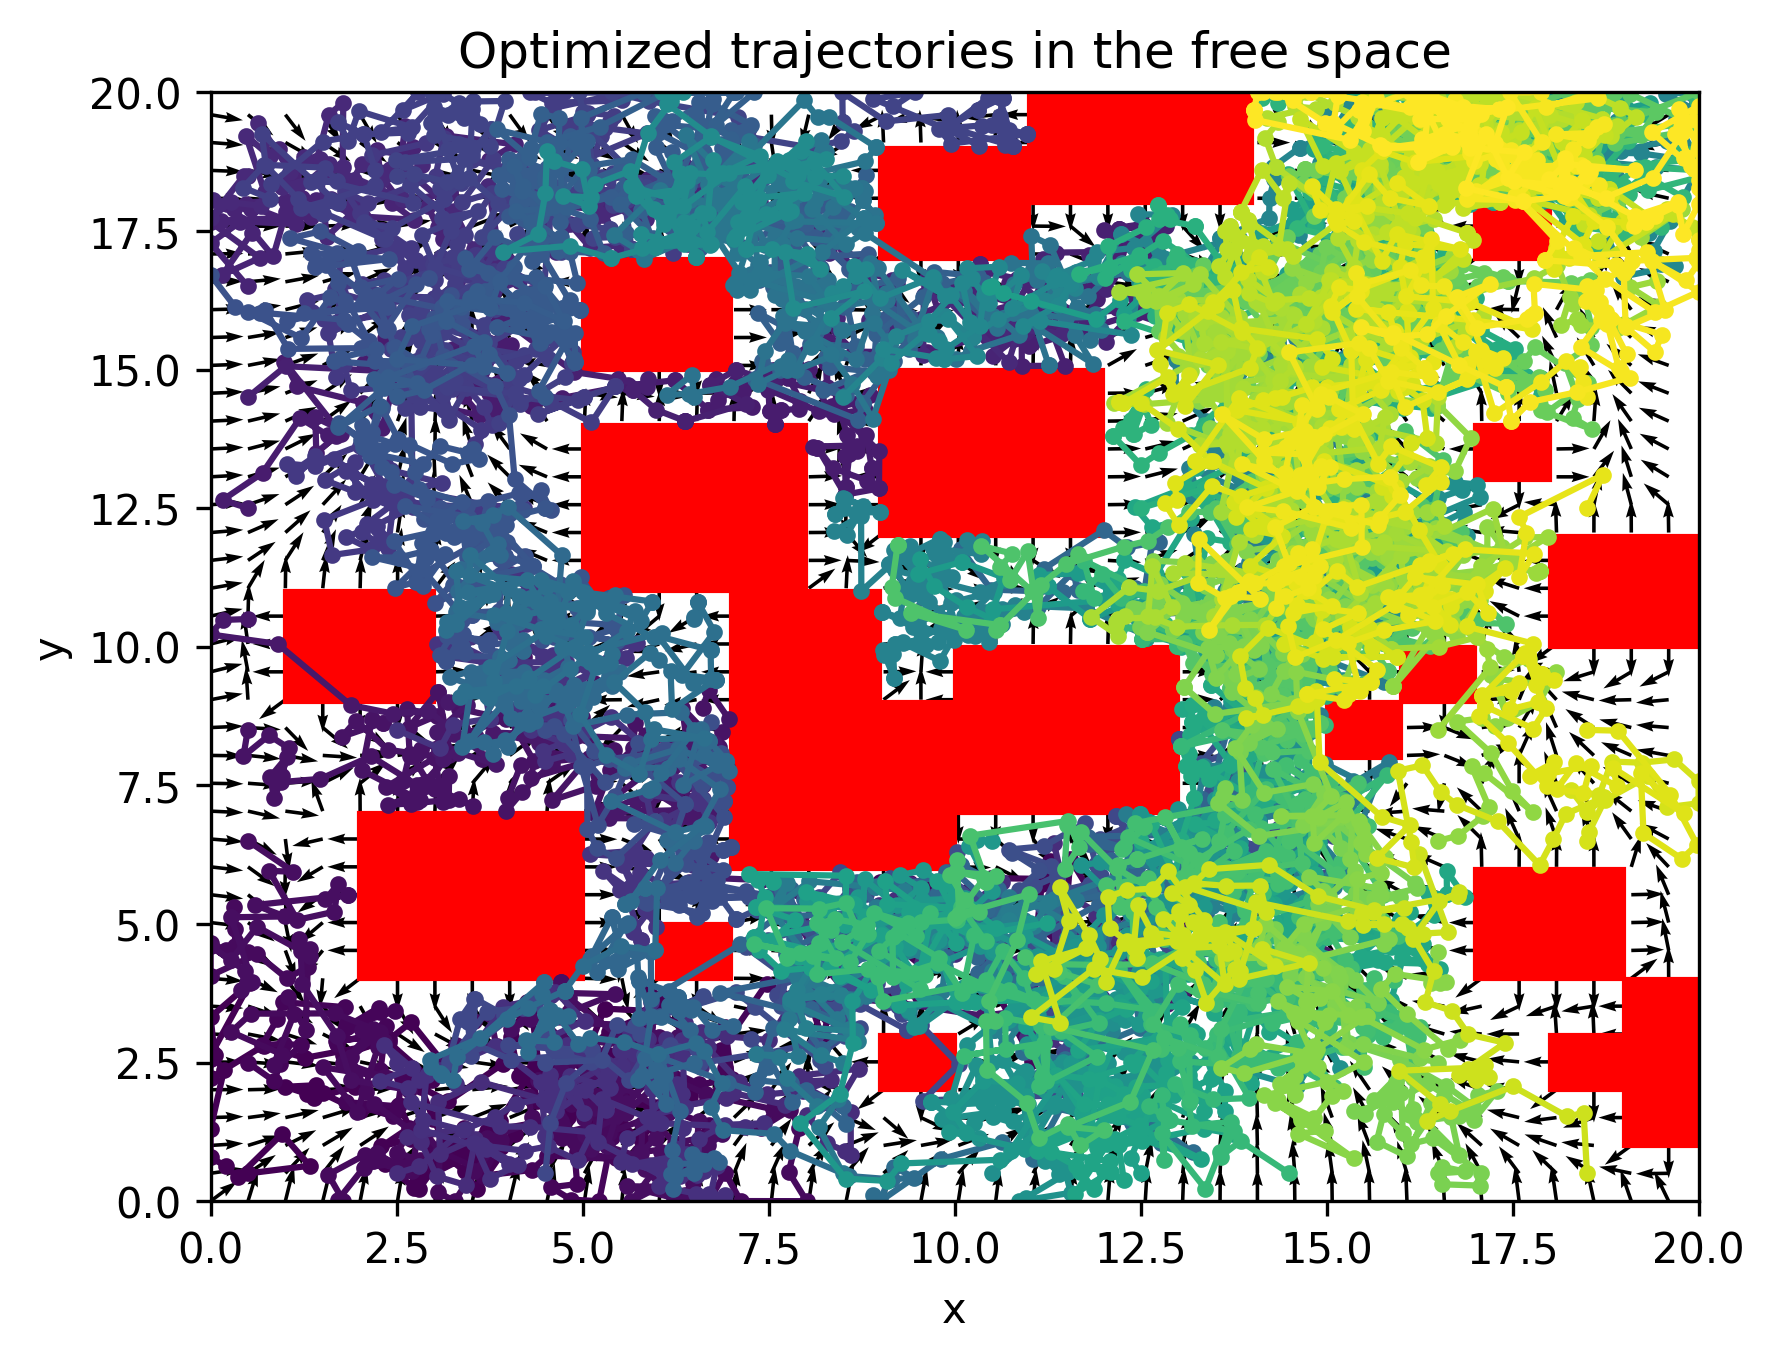

In [15]:
downscale = 5
scale = 2
# Visualisation
fig = vis.plot_2D_trajectory(simulation.positions, goal_position, obstacles=env.obstacles, vector_field=simulation.force_field, downscale=downscale, scale = scale, title="Optimized trajectories in the free space")
plt.xlim(0, env.width)
plt.ylim(0, env.height)

In [ ]:
fig.savefig("2D_noisy_diffusion_simulation.svg")

# Bending constraints
Let now try to implement bending constraints on the walker position

In [52]:
from typing import List

from snake_ai.diffsim.field import ScalarField
from snake_ai.envs.geometry import Rectangle

@ti.data_oriented
class BendingSimulation(WalkerSimulationStoch2D):
    def __init__(self, positions: np.ndarray, potential_field: ScalarField, obstacles: List[Rectangle] = None, t_max: float = 100, dt: float = 0.1, diffusivity: float = 1):
        super().__init__(positions, potential_field, obstacles, t_max, dt, diffusivity) 
        self.distance_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.bending_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.obstacle_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)
        self.total_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)

    @ti.kernel
    def reset(self):
        for n in ti.ndrange(self.nb_walkers):
            self.states[n, 0].pos = self._init_pos[n]
            self.states[n, 0].vel = tm.vec2(0.0, 0.0)
            for t in ti.ndrange(self.nb_steps):
                self._noise[n, t] = tm.vec2(ti.randn(), ti.randn())
        for i, j in self.force_field._values:
            self.force_field._values.grad[i, j] = tm.vec2(0.0, 0.0)
        self.distance_loss[None] = 0.0
        self.bending_loss[None] = 0.0
        self.total_loss[None] = 0.0

    
    @ti.kernel
    def clip_force_field(self, clip_value: float):
        for i, j in self.force_field._values:
            if tm.length(self.force_field._values.grad[i, j]) > clip_value:
                self.force_field._values.grad[i, j] = (
                    clip_value
                    * self.force_field._values.grad[i, j]
                    / tm.length(self.force_field._values.grad[i, j])
                )
    @ti.kernel
    def compute_distance_loss(self, target : ti.template(), t : int):
        for n in range(self.nb_walkers):
            ti.atomic_add(self.distance_loss[None], tm.length(self.states[n, t].pos - target)**2)
    
    @ti.kernel
    def compute_bending_loss(self, min_diff : float):
        for n in range(self.nb_walkers):
            for t in range(self.nb_steps - 1):
                F_t1 = self.force_field._at_2d(self.states.pos[n, t])
                F_t2 = self.force_field._at_2d(self.states.pos[n, t + 1])
                f_diff = F_t2 - F_t1
                if tm.length(f_diff) < min_diff:
                    ti.atomic_add(self.bending_loss[None], 0.0)
                else:
                    bending = tm.atan2(tm.length(f_diff), tm.dot(F_t1, f_diff))

                    ti.atomic_add(self.bending_loss[None], bending**2)

    @ti.kernel
    def compute_total_loss(self, distance : float, bending : float):
        self.total_loss[None] = distance * self.distance_loss[None] + bending * self.bending_loss[None]

In [53]:
diffusivity = 0.1
t_max = 50
positions = np.array([[6.5, 10.5], [10.5, 10.5]])
positions = np.repeat(positions, 10, axis=0)

simulation = BendingSimulation(positions, log_concentration, obstacles=env.obstacles, t_max=t_max, dt=dt, diffusivity=diffusivity)
simulation.reset()
simulation.run(diffusivity=diffusivity)

[W 05/02/24 18:28:01.777 12703] [type_check.cpp:type_check_store@36] [$85224] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                        ^^^^^^^^^^^^^^^^^^^^^

[W 05/02/24 18:28:01.777 12703] [type_check.cpp:type_check_store@36] [$85247] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                        ^^^^^^^^^^^^^^^^^^^^^

[W 05/02/24 18:28:02.029 12703] [type_check.cpp:type_check_store@36] [$86175] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
               

(0.0, 20.0)

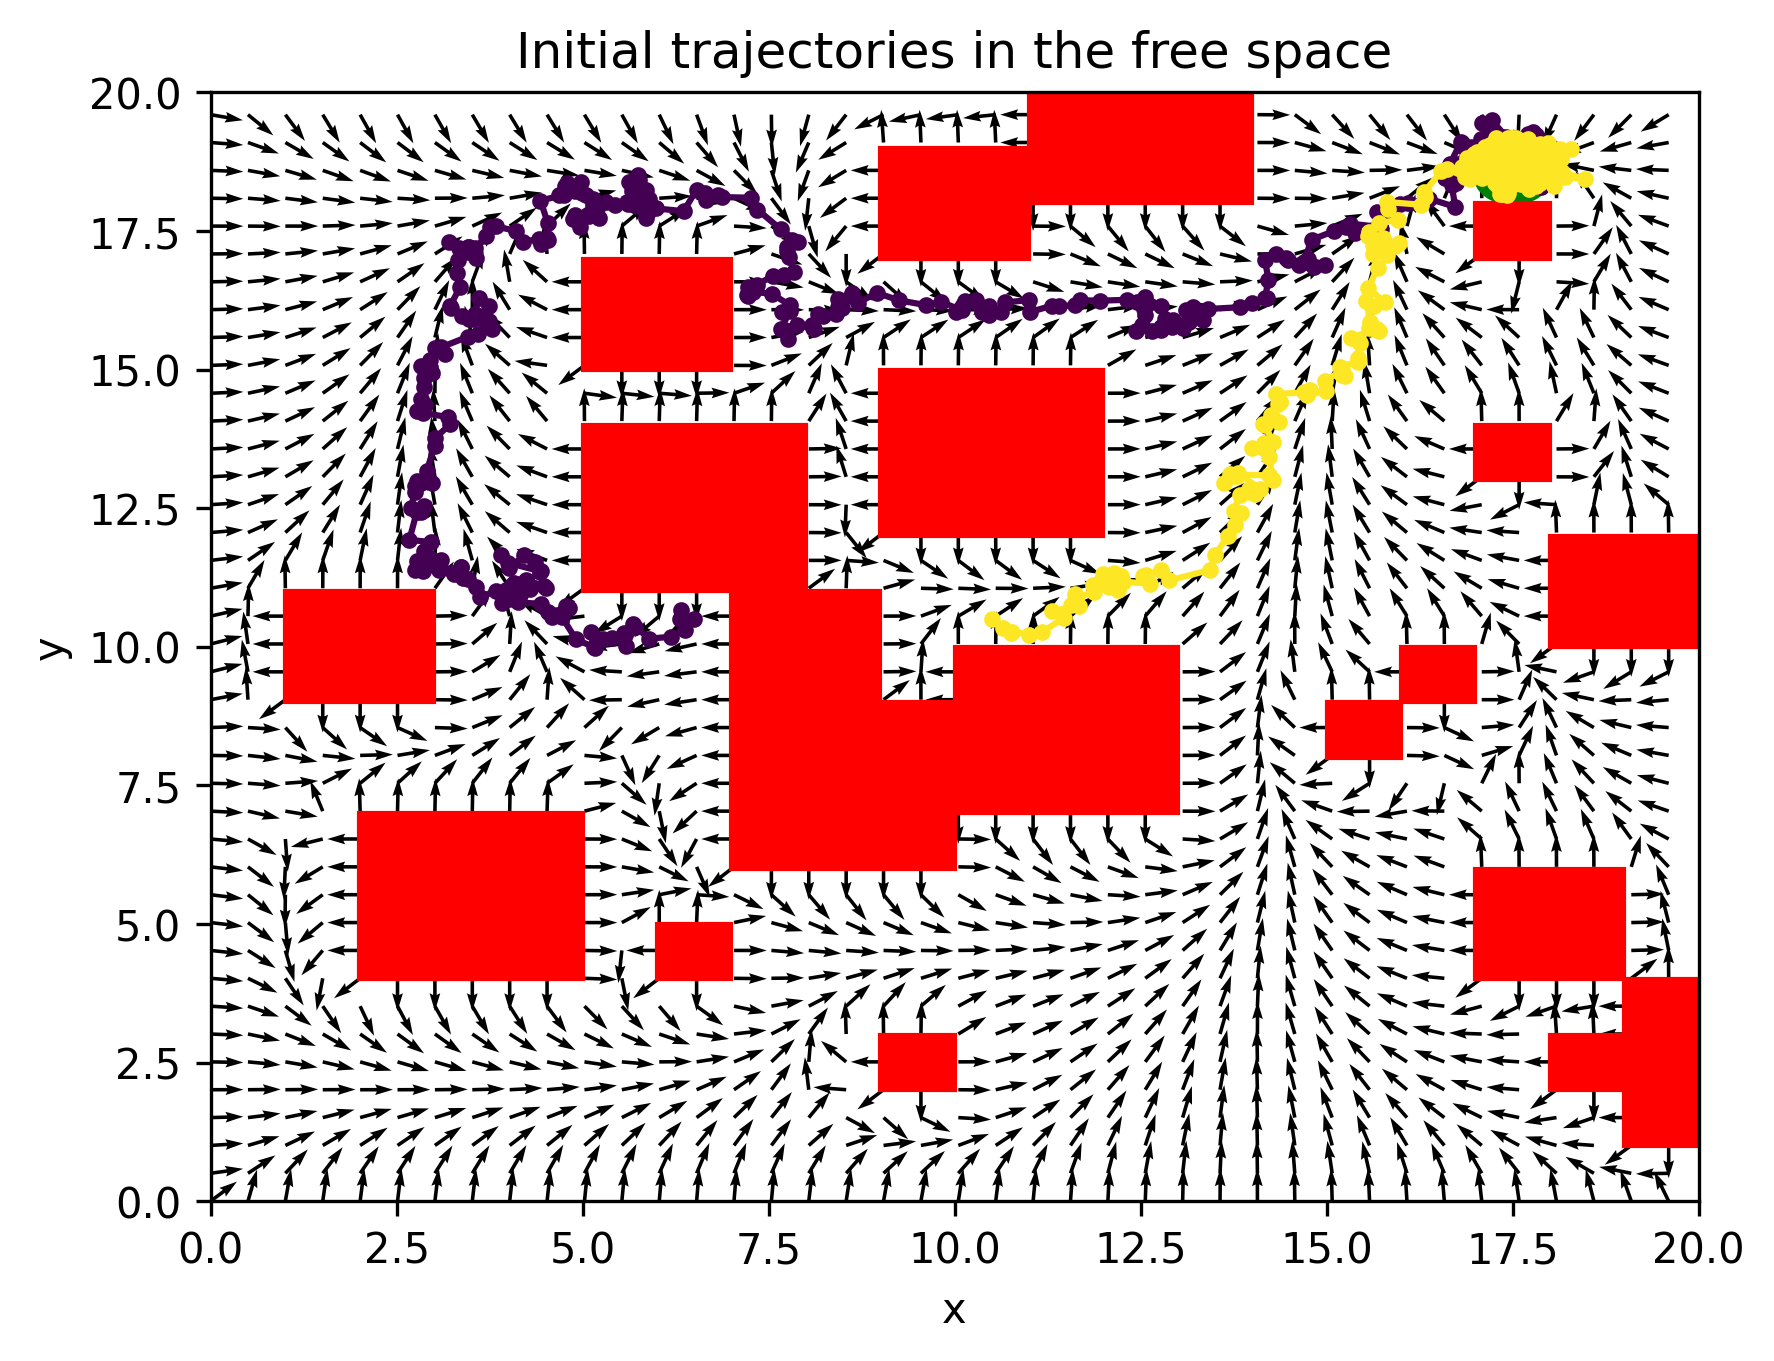

In [54]:
# Visualisation
downscale = 5
scale = 2
fig = vis.plot_2D_trajectory(simulation.positions[::10], goal_position, obstacles=env.obstacles, vector_field=simulation.force_field, downscale=downscale, scale=scale, title="Initial trajectories in the free space")
plt.xlim(0, env.width)
plt.ylim(0, env.height)

In [39]:
fig.savefig("2D_bending_simulation.svg")

Now let make ther optimisation loop explicit

In [55]:
max_iter = 100
lr = 0.01
clip = 10.0
w_distance, w_bend = 100.0, 10.0

best_loss = np.inf
best_vector_field = None

target = tm.vec2(*goal_position)
for iter in range(max_iter):
    simulation.reset()
    with ti.ad.Tape(simulation.total_loss):
        simulation.run(diffusivity=diffusivity)
        simulation.compute_distance_loss(target, simulation.nb_steps - 1)
        simulation.compute_bending_loss(1e-6)
        simulation.compute_total_loss(w_distance, w_bend)
    if simulation.total_loss[None] < best_loss:
        best_loss = simulation.total_loss[None]
        best_vector_field = np.copy(simulation.force_field._values.to_numpy())
    print("Iter=", iter, "Loss=", simulation.total_loss[None], "Distance=", simulation.distance_loss[None], "Bending=", simulation.bending_loss[None])
    if clip > 0:
        simulation.clip_force_field(clip)
    simulation._update_force_field(lr)

Iter= 0 Loss= 339792.9375 Distance= 3.1215200424194336 Bending= 33948.078125
Iter= 1 Loss= 345748.25 Distance= 2.4512879848480225 Bending= 34550.3125
Iter= 2 Loss= 341797.4375 Distance= 3.2278623580932617 Bending= 34147.46484375
Iter= 3 Loss= 340313.0625 Distance= 3.433875322341919 Bending= 33996.96875
Iter= 4 Loss= 329846.8125 Distance= 3.6744537353515625 Bending= 32947.9375
Iter= 5 Loss= 326035.0625 Distance= 6.820306777954102 Bending= 32535.3046875
Iter= 6 Loss= 321412.1875 Distance= 3.4761834144592285 Bending= 32106.45703125
Iter= 7 Loss= 316267.1875 Distance= 4.214162826538086 Bending= 31584.578125
Iter= 8 Loss= 312690.3125 Distance= 6.495694160461426 Bending= 31204.07421875
Iter= 9 Loss= 308838.53125 Distance= 6.671321868896484 Bending= 30817.140625
Iter= 10 Loss= 305660.21875 Distance= 6.644224166870117 Bending= 30499.580078125
Iter= 11 Loss= 303725.34375 Distance= 7.524226188659668 Bending= 30297.29296875
Iter= 12 Loss= 300645.8125 Distance= 10.029658317565918 Bending= 29964.28

(0.0, 20.0)

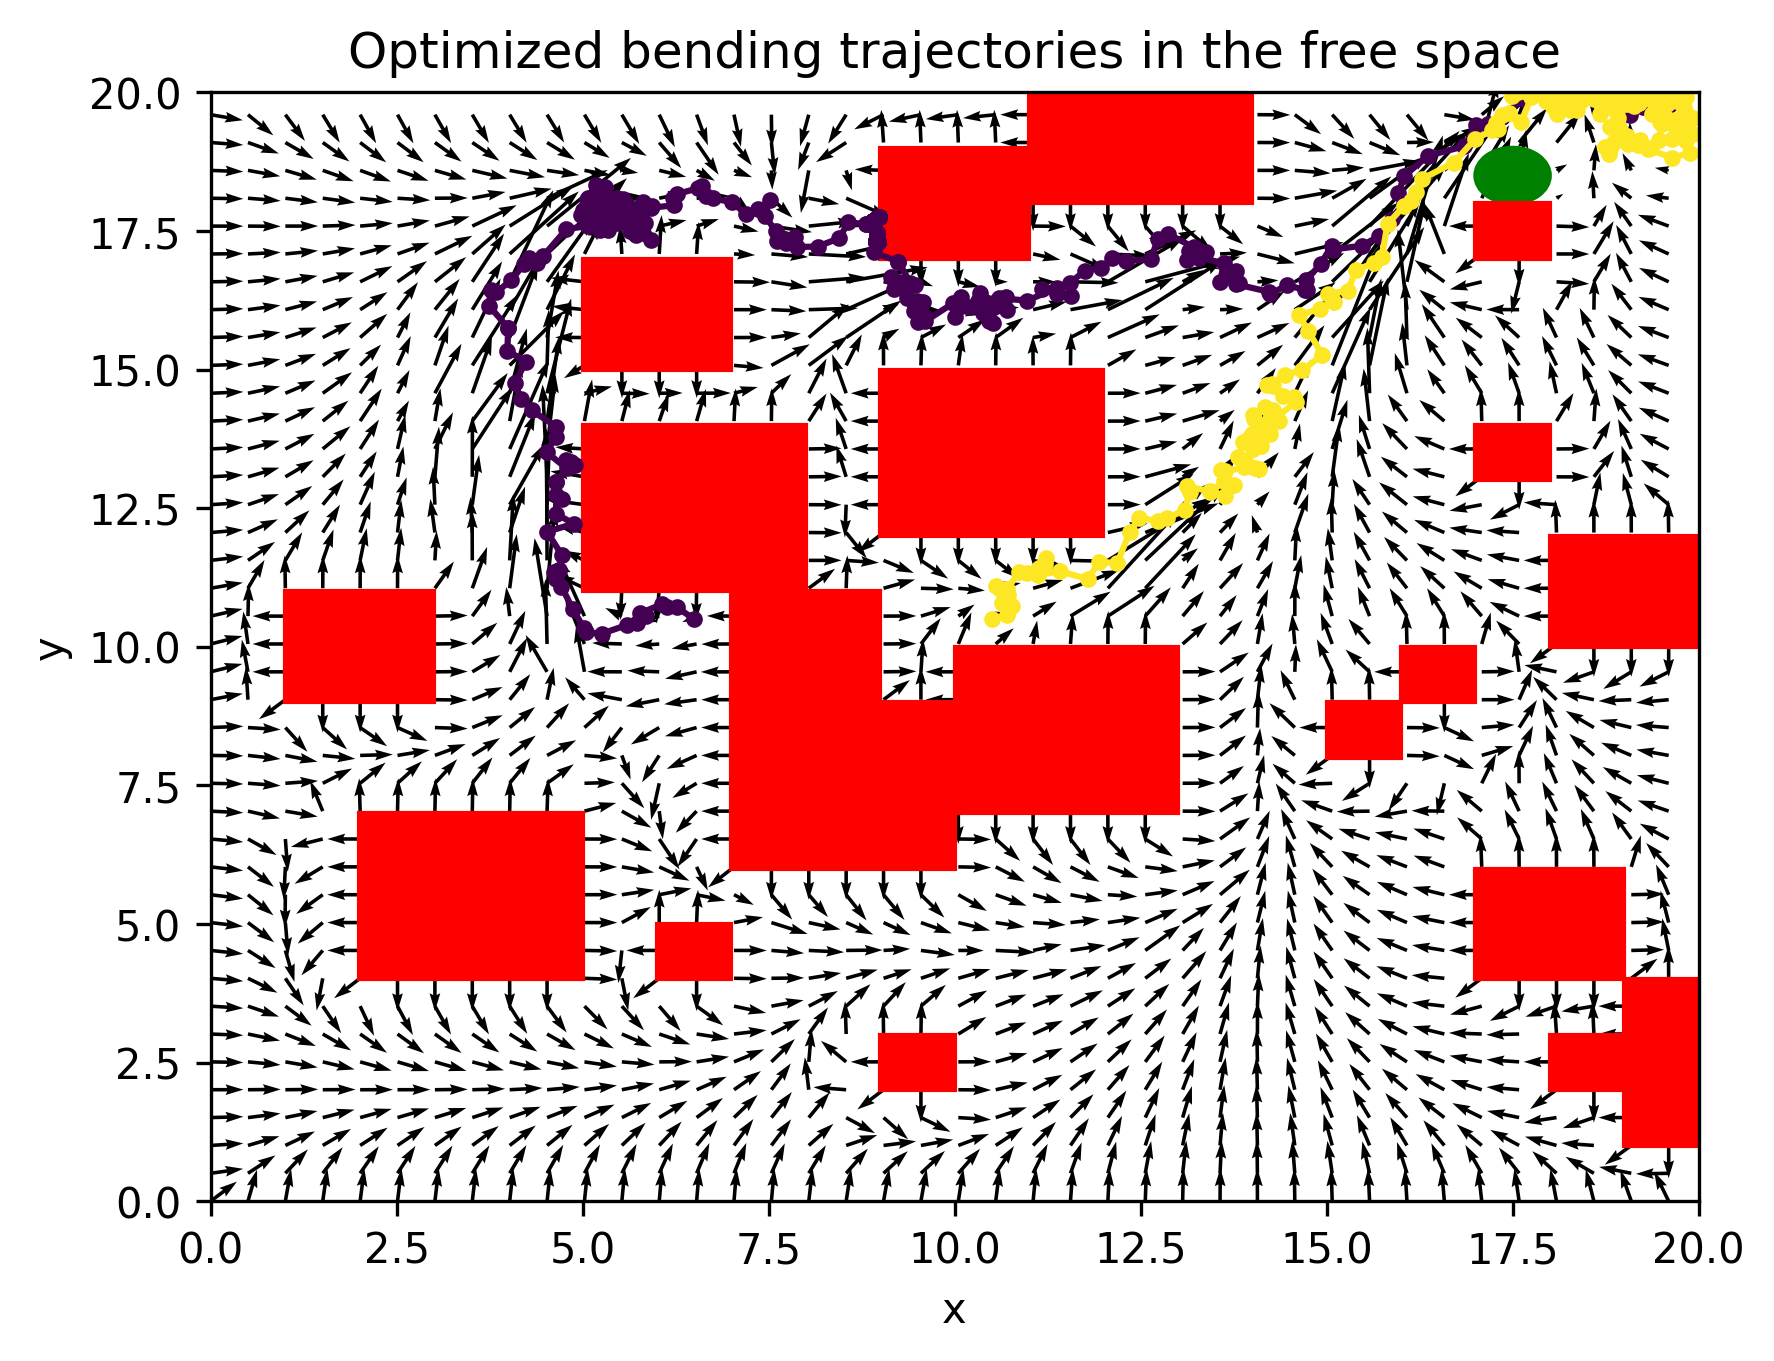

In [57]:
fig = vis.plot_2D_trajectory(simulation.positions[::10], goal_position, env.obstacles, vector_field=simulation.force_field, downscale=downscale, scale=scale, title="Optimized bending trajectories in the free space")
plt.xlim(0, env.width)
plt.ylim(0, env.height)

In [37]:
fig.savefig("2D_bending_diffusion_simulation_optim.png")

In [34]:
simulation.force_field._values.from_numpy(best_vector_field)
simulation.reset()
# simulation.diffusivity = 0.1
# simulation.force_field = force_field
simulation.run(diffusivity=0.1)

(0.0, 20.0)

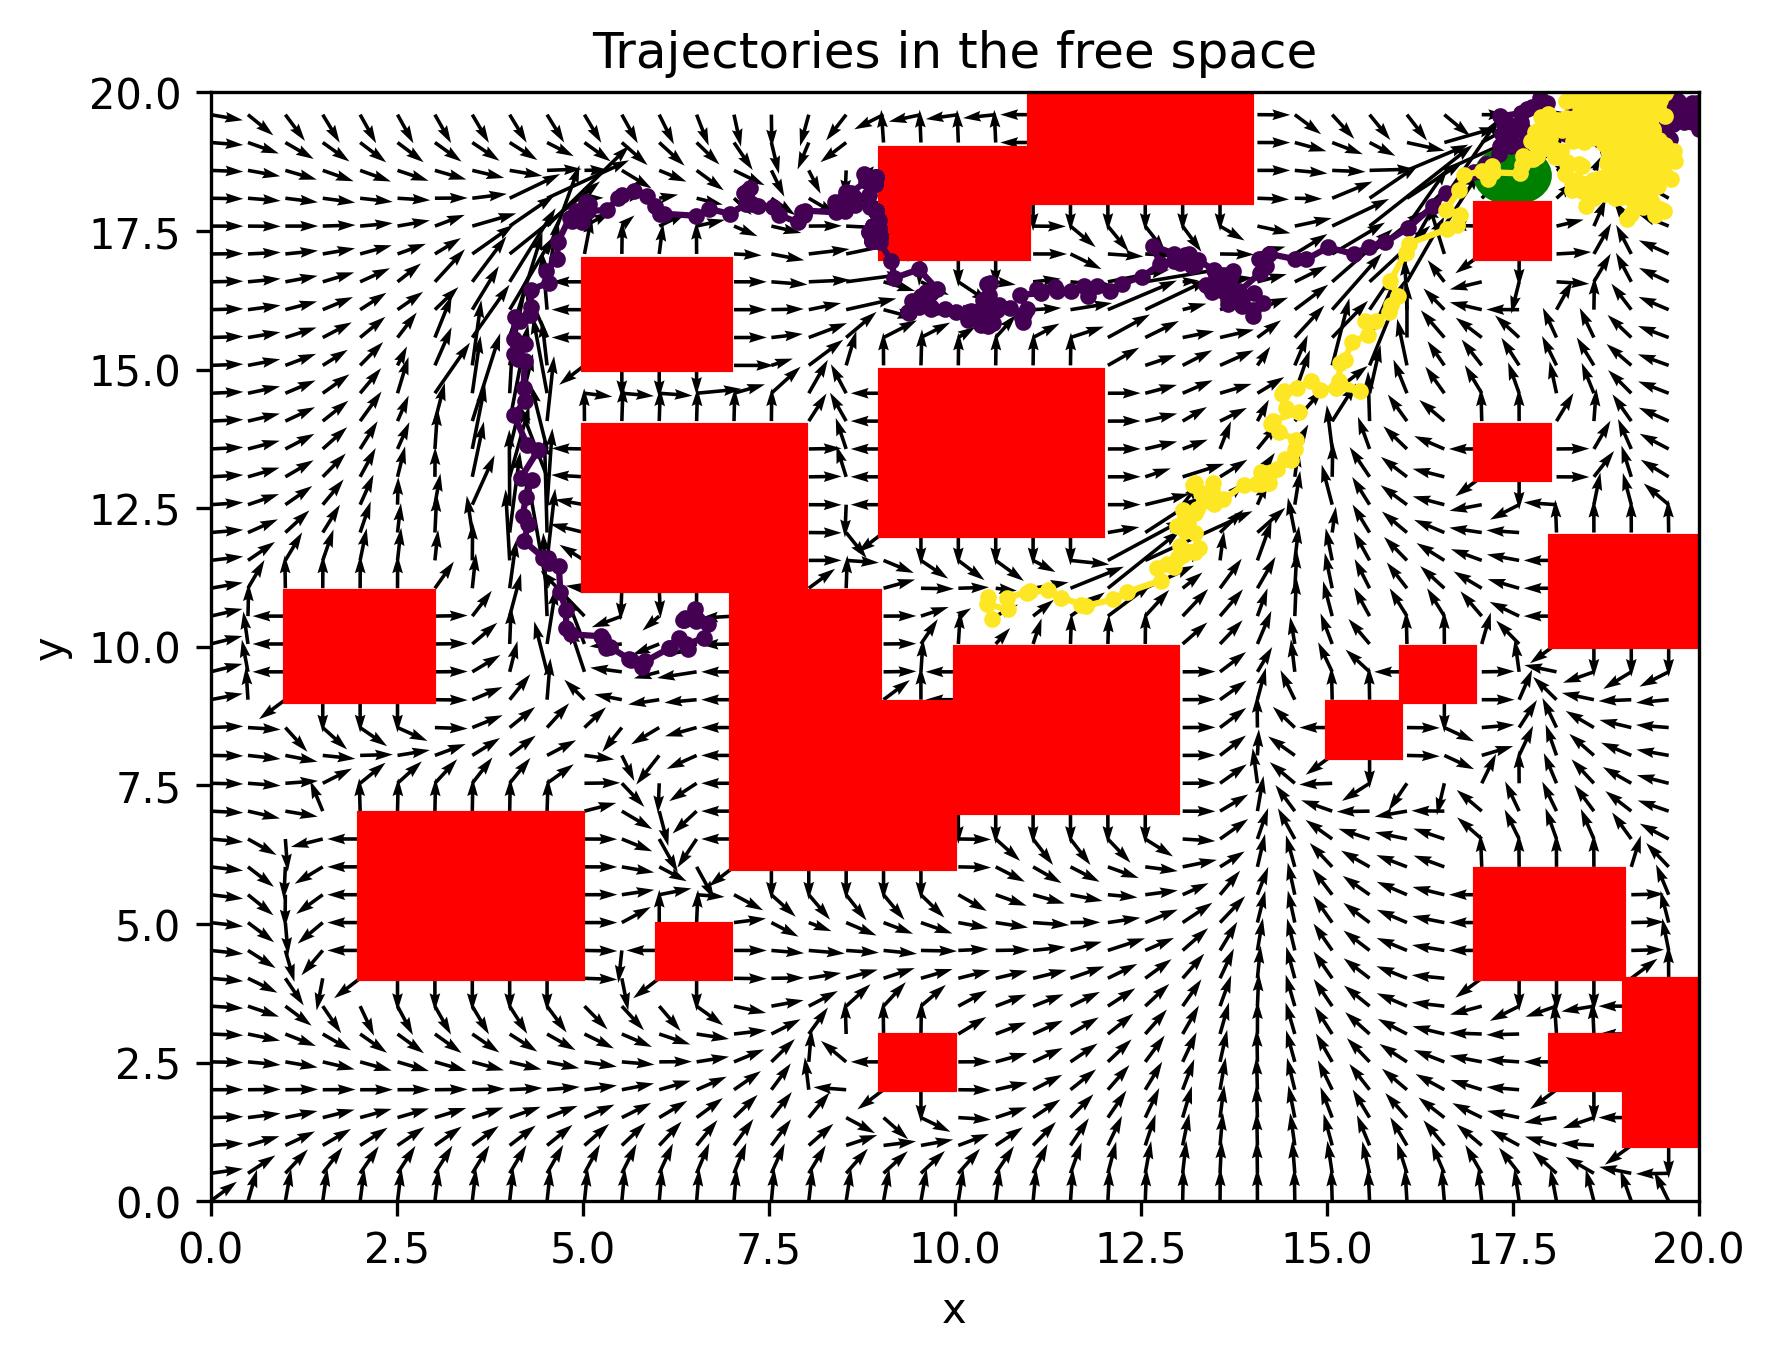

In [35]:
vis_positions = simulation.positions[5::10]
fig = vis.plot_2D_trajectory(vis_positions, goal_position, env.obstacles, vector_field=simulation.force_field, downscale=downscale, scale=scale, title="Trajectories in the free space")
plt.xlim(0, env.width)
plt.ylim(0, env.height)

## Obstacle distances field
Now let's try to avoid collisions with obstacles 

In [58]:
from typing import List


from numpy import ndarray


from snake_ai.diffsim.field import ScalarField
from snake_ai.envs.geometry import Rectangle


class CollisionBendingSimulation(BendingSimulation):
    def __init__(self, positions: ndarray, potential_field: ScalarField, distance_map : ScalarField, obstacles: List[Rectangle] = None, t_max: float = 100, dt: float = 0.1, diffusivity: float = 1):
        super().__init__(positions, potential_field, obstacles, t_max, dt, diffusivity)
        assert isinstance(distance_map, ScalarField)
        self.distance_map = distance_map
        self.distance_force = spatial_gradient(distance_map, needs_grad=True)
        self.distance_force.normalize()
        self.obstacle_loss = ti.field(dtype=ti.f32, shape=(), needs_grad=True)

    @ti.kernel
    def compute_obstacle_loss(self, min_diff : float, collision_length : float):
        for n in range(self.nb_walkers):
            for t in range(self.nb_steps):
                f1 = self.force_field._at_2d(self.states.pos[n, t])
                f2 = self.distance_force._at_2d(self.states.pos[n, t])
                if tm.length(f2) == 0.0 or tm.length(f1) == 0.0:
                    ti.atomic_add(self.obstacle_loss[None], 0.0)
                else:
                    f1n = tm.normalize(f1)
                    f2n = tm.normalize(f2)
                    dist = self.distance_map._at_2d(self.states.pos[n, t])

                    f_diff = f2n - f1n
                    if tm.length(f_diff) < min_diff:
                        ti.atomic_add(self.obstacle_loss[None], 0.0)
                    else:
                        bending = tm.atan2(
                            tm.length(f_diff), tm.dot(f1n, f_diff)
                        )

                        ti.atomic_add(
                            self.obstacle_loss[None],
                            bending ** 2
                            * tm.exp(-0.5 * dist**2 / collision_length),
                        )

    @ti.kernel
    def compute_total_loss(self, distance : float, bending : float, obstacle : float):
        self.total_loss[None] = distance * self.distance_loss[None] + bending * self.bending_loss[None] + obstacle * self.obstacle_loss[None]

We first need to create a signed distance map from the obstacle map. We are going to take the same resolution than the obstacles but it can be different. 

[Text(0.5, 1.0, 'Signed distance map')]

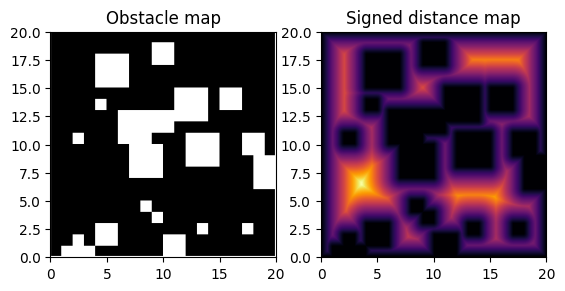

In [59]:
import scipy.ndimage as ndimage
obstacle_map = converter.convert_obstacles_to_binary_map()
# Add artificial obstacles to the border
obstacle_map[0, :] = 1
obstacle_map[-1, :] = 1
obstacle_map[:, 0] = 1
obstacle_map[:, -1] = 1
## Compute the signed distance map
sdf_map = ndimage.distance_transform_edt(~obstacle_map, sampling=force_field.step_sizes)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(obstacle_map, cmap='gray',  extent=[0, env.width, 0, env.height])
ax[0].set(title="Obstacle map")
ax[1].imshow(sdf_map, cmap='inferno',  extent=[0, env.width, 0, env.height])
ax[1].set(title="Signed distance map")


In [163]:
# Define the parameter of the simulation
positions = np.array([[9.5, 5.5]])
positions = np.repeat(positions, 100, axis=0)
diffusivity = 0.1
t_max = 100
dt = 0.1

distance_field = ScalarField(sdf_map, Rectangle(0, 0, env.width, env.height))

simulation = CollisionBendingSimulation(positions, log_concentration, distance_field, obstacles=env.obstacles, t_max=t_max, dt=dt, diffusivity=diffusivity)
simulation.reset()
simulation.run(diffusivity=diffusivity)

[W 05/02/24 20:31:52.086 12703] [type_check.cpp:type_check_store@36] [$184584] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 127, in ext_arr_to_tensor:
        tensor[I] = arr[I]
        ^^^^^^^^^^^^^^^^^^

[W 05/02/24 20:31:52.162 12703] [type_check.cpp:type_check_store@36] [$184714] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                        ^^^^^^^^^^^^^^^^^^^^^

[W 05/02/24 20:31:52.162 12703] [type_check.cpp:type_check_store@36] [$184737] Global store may lose precision: f32 <- f64
File "/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/taichi/_kernels.py", line 188, in ext_arr_to_matrix:
                        mat[I][p] = arr[I, p]
                        ^^^^^^^^^^^^^^^^^^^^^

[W 

(0.0, 20.0)

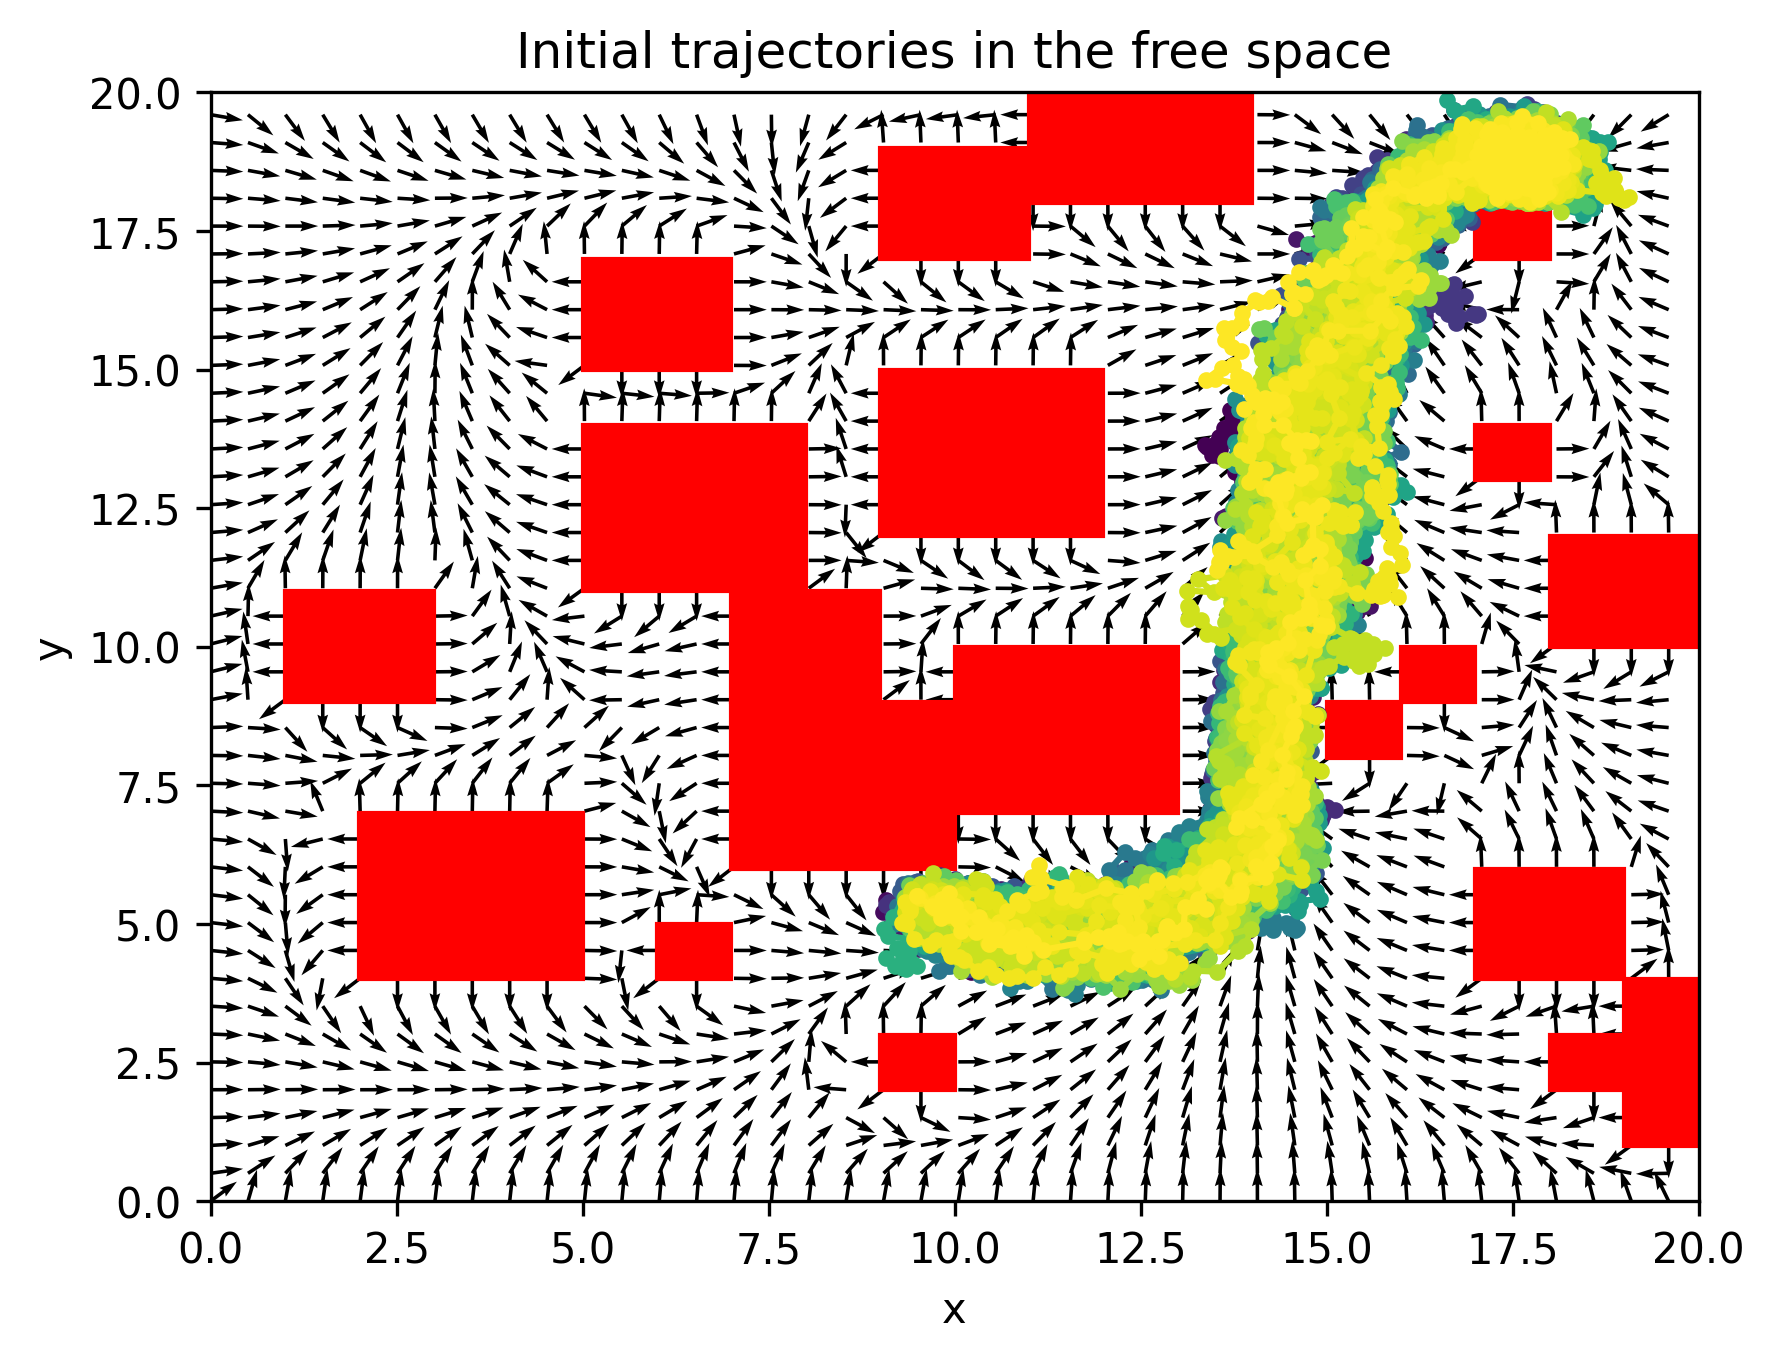

In [164]:
init_positions = simulation.positions
init_vector_field = simulation.force_field
## Visualisation of initial trajectories
fig = vis.plot_2D_trajectory(
    simulation.positions,
    goal_position, 
    env.obstacles,
    vector_field=simulation.force_field,
    downscale = downscale, 
    scale = scale,
    title="Initial trajectories in the free space"
    )
plt.xlim(0, env.width)
plt.ylim(0, env.height)

Optimization of the cost function without bending

In [168]:
max_iter = 50
lr = 0.1
clip = 1.0

best_loss = np.inf
best_vector_field = None
collision_length = 5.0
min_diff = 1e-6

w_dist, w_bending, w_obstacle = 1.0, 0.0, 10.

target = tm.vec2(*goal_position)
for iter in range(max_iter):
    simulation.reset()
    with ti.ad.Tape(simulation.total_loss):
        simulation.run(diffusivity=diffusivity)
        simulation.compute_distance_loss(target, simulation.nb_steps - 1)
        simulation.compute_obstacle_loss(min_diff, collision_length=collision_length)
        # simulation.compute_bending_loss(min_diff)
        simulation.compute_total_loss(w_dist, w_bending, w_obstacle)
    if simulation.total_loss[None] < best_loss:
        best_loss = simulation.total_loss[None]
        best_vector_field = np.copy(simulation.force_field._values.to_numpy())
    print("Iter=", iter, ", Loss=", simulation.total_loss[None], "\nDistance=", simulation.distance_loss[None], ", Bending=", simulation.bending_loss[None], ", Obstacles=", simulation.obstacle_loss[None])
    if clip > 0:
        simulation.clip_force_field(clip)
    simulation._update_force_field(lr)

Iter= 0 , Loss= 3836191.75 
Distance= 16.12921714782715 , Bending= 0.0 , Obstacles= 383617.5625
Iter= 1 , Loss= 7615322.0 
Distance= 15.689095497131348 , Bending= 0.0 , Obstacles= 761530.625
Iter= 2 , Loss= 11322221.0 
Distance= 16.359922409057617 , Bending= 0.0 , Obstacles= 1132220.5
Iter= 3 , Loss= 14959264.0 
Distance= 18.95195960998535 , Bending= 0.0 , Obstacles= 1495924.5
Iter= 4 , Loss= 18526850.0 
Distance= 14.685318946838379 , Bending= 0.0 , Obstacles= 1852683.625
Iter= 5 , Loss= 22029632.0 
Distance= 22.378835678100586 , Bending= 0.0 , Obstacles= 2202961.0
Iter= 6 , Loss= 25442438.0 
Distance= 21.382213592529297 , Bending= 0.0 , Obstacles= 2544241.75
Iter= 7 , Loss= 28764902.0 
Distance= 25.413835525512695 , Bending= 0.0 , Obstacles= 2876487.75
Iter= 8 , Loss= 31987860.0 
Distance= 35.35416793823242 , Bending= 0.0 , Obstacles= 3198782.5
Iter= 9 , Loss= 35070580.0 
Distance= 64.42400360107422 , Bending= 0.0 , Obstacles= 3507051.75
Iter= 10 , Loss= 37814852.0 
Distance= 366.2154

(0.0, 20.0)

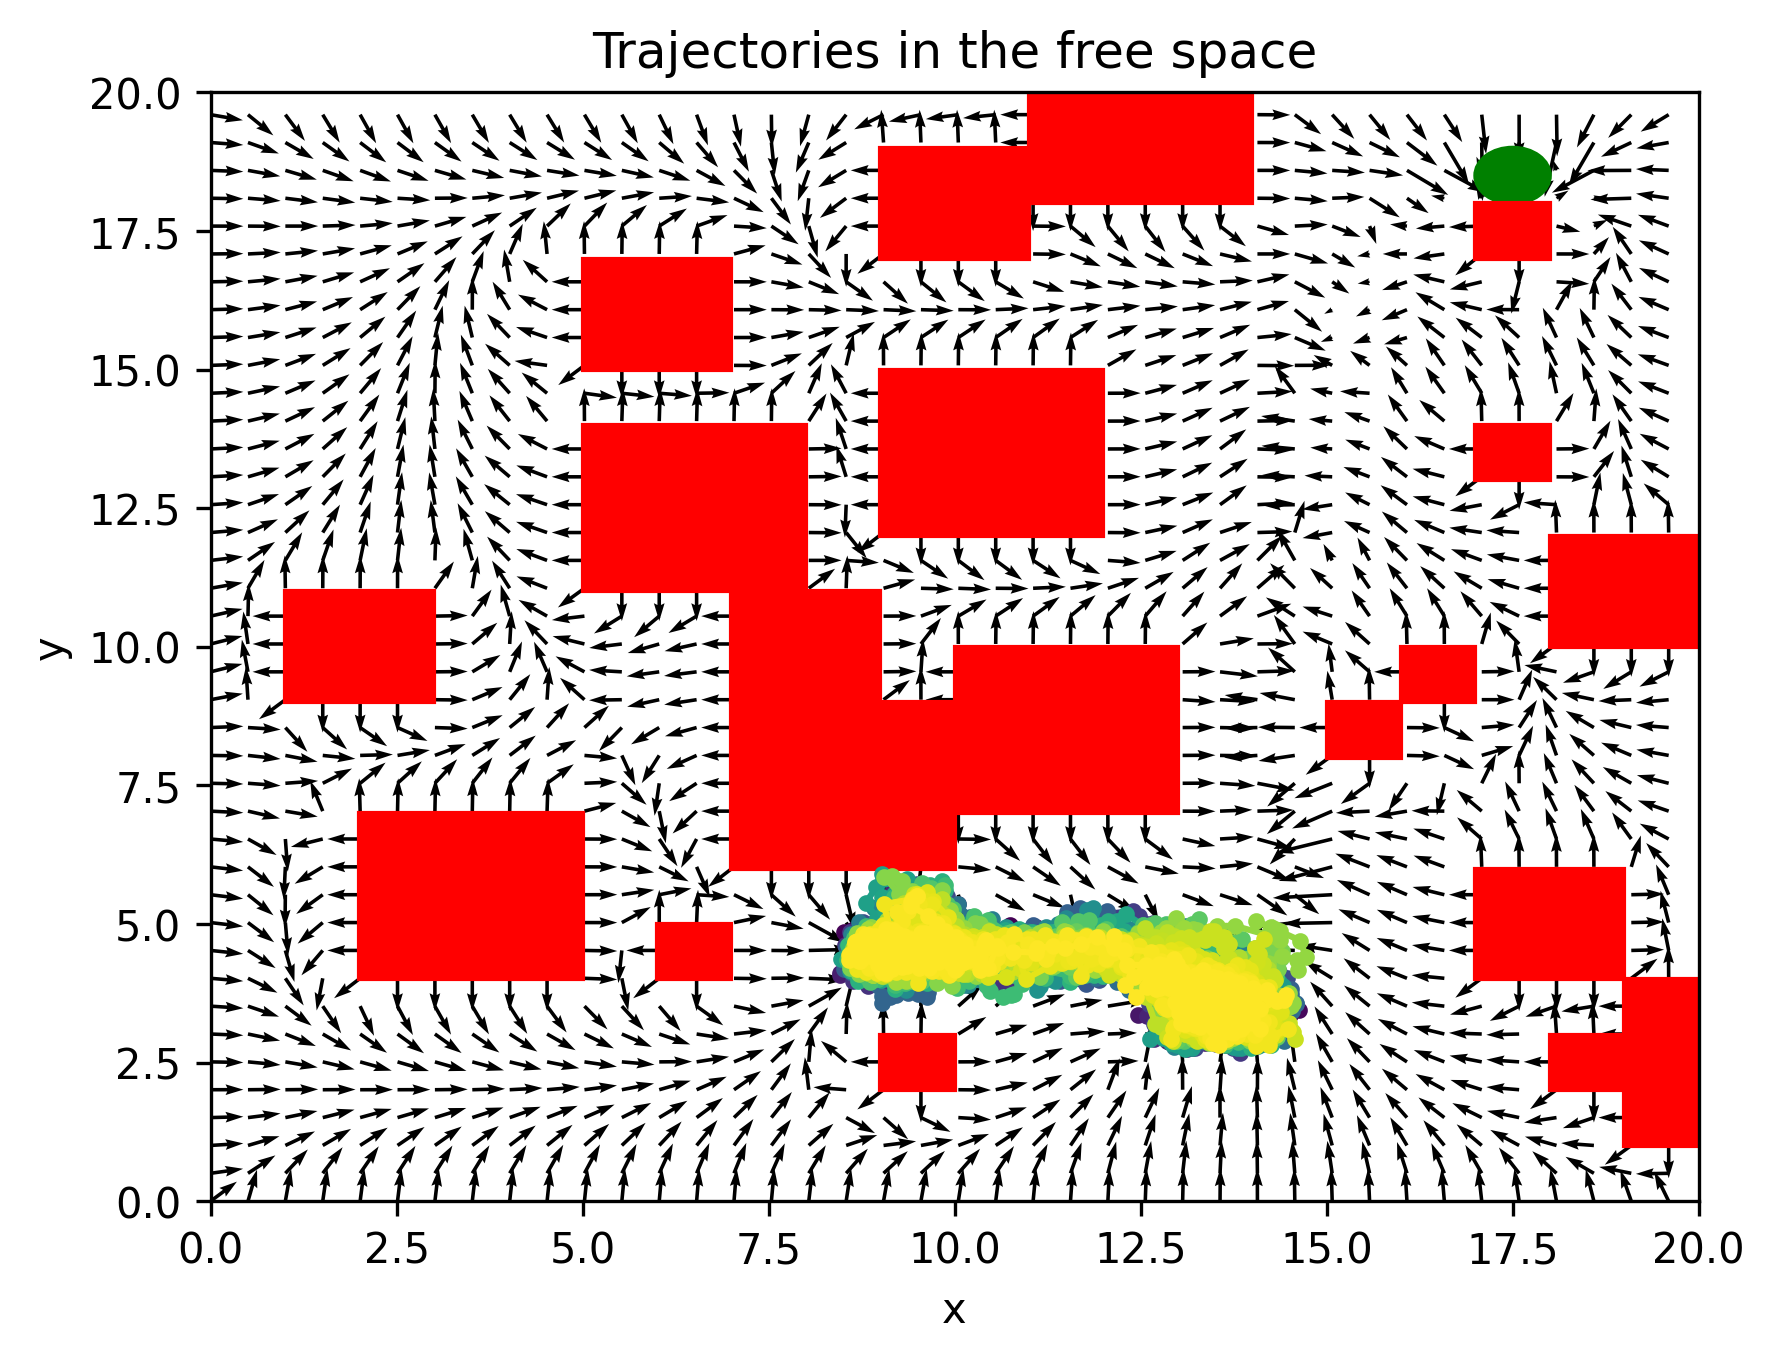

In [172]:
from snake_ai.diffsim.field import VectorField
final_positions = simulation.positions
values = np.stack([best_vector_field[:,:,0], best_vector_field[:,:,1]], axis=0)
final_vector_field = VectorField(values, Rectangle(0, env.width, 0, env.height))
fig = vis.plot_2D_trajectory(simulation.positions, goal_position, env.obstacles, vector_field=simulation.force_field, downscale=downscale, scale=scale, title="Trajectories in the free space")
plt.xlim(0, env.width)
plt.ylim(0, env.height)

## Visualisation of the differences

In [83]:
def compare_2D_trajectories(
    init_trajectories: np.ndarray,
    final_trajectories: np.ndarray,
    goal: np.ndarray,
    obstacles: List[Rectangle],
    title: str = "Trajectories comparision",
):
    """Plot the trajectories of multiple walkers in 2D with a color corresponding to their concentration.

    Args:
        init_trajectories (np.ndarray): positions before optimization
        final_trajectories (np.ndarray): positions after optimization
        goal (np.ndarray): position of the goal
        obstacles (List[Rectangle]): position of the goal
    """
    colormaps = ["viridis", "inferno", "plasma", "cividis", "magma"] + ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
    assert isinstance(init_trajectories, np.ndarray) and init_trajectories.ndim == 3
    assert np.array_equal(init_trajectories[:,0], final_trajectories[:,0]), "Expected same initial positions"
    assert init_trajectories.shape == final_trajectories.shape, "Expected same shape"
    
    fig, ax = plt.subplots(1, 1, dpi=300)
    for i in range(init_trajectories.shape[0]):
        ax.scatter(
            init_trajectories[i, :, 0],
            init_trajectories[i, :, 1],
            c=np.arange(init_trajectories.shape[1]),
            cmap=colormaps[0],
            marker=".",
        )
        ax.scatter(
            final_trajectories[i, :, 0],
            final_trajectories[i, :, 1],
            c=np.arange(final_trajectories.shape[1]),
            cmap=colormaps[1],
            # linestyle="-",
            marker=".",
        )
    for obs in obstacles:
        ax.add_patch(plt.Rectangle((obs.x, obs.y), obs.width, obs.height, color="red"))
    ax.add_patch(plt.Circle(goal, 0.5, color="green"))
    ax.add_patch(plt.Circle(init_trajectories[0,0], 0.5, color="blue"))
    ax.set(title=title, xlabel="x", ylabel="y")
    return fig

In [130]:
def compare_2D_trajectories_mean(init_trajectories, final_trajectories, goal, obstacles, title="Trajectories comparision"):

    mean_init = np.mean(init_trajectories, axis=0)
    mean_final = np.mean(final_trajectories, axis=0)
    std_init = np.std(init_trajectories, axis=0)
    std_final = np.std(final_trajectories, axis=0)

    fig, ax = plt.subplots(1, 1, dpi=300)
    # Plot the initial trajectories
    ax.plot(mean_init[:, 0], mean_init[:, 1], c="blue", label="Initial trajectories")
    ax.fill_between(mean_init[:,0], mean_init[:,1] + std_init[:, 1], mean_init[:,1] - std_init[:,1], 
                    alpha=0.2, color="blue")
    # Plot the final trajectories
    ax.plot(mean_final[:, 0], mean_final[:, 1], c="orange", label="Final trajectories")
    ax.fill_between(mean_final[:,0], mean_final[:,1] + std_final[:, 1], mean_final[:,1] - std_final[:,1], 
                    alpha=0.2, color="orange")
    
 
    for obs in obstacles:
        ax.add_patch(plt.Rectangle((obs.x, obs.y), obs.width, obs.height, color="red"))
    ax.add_patch(plt.Circle(goal, 0.5, color="green"))
    ax.add_patch(plt.Circle(mean_init[0], 0.5, color="blue"))
    fig.legend(loc='upper right')
    ax.set(title=title, xlabel="x", ylabel="y")
    return fig

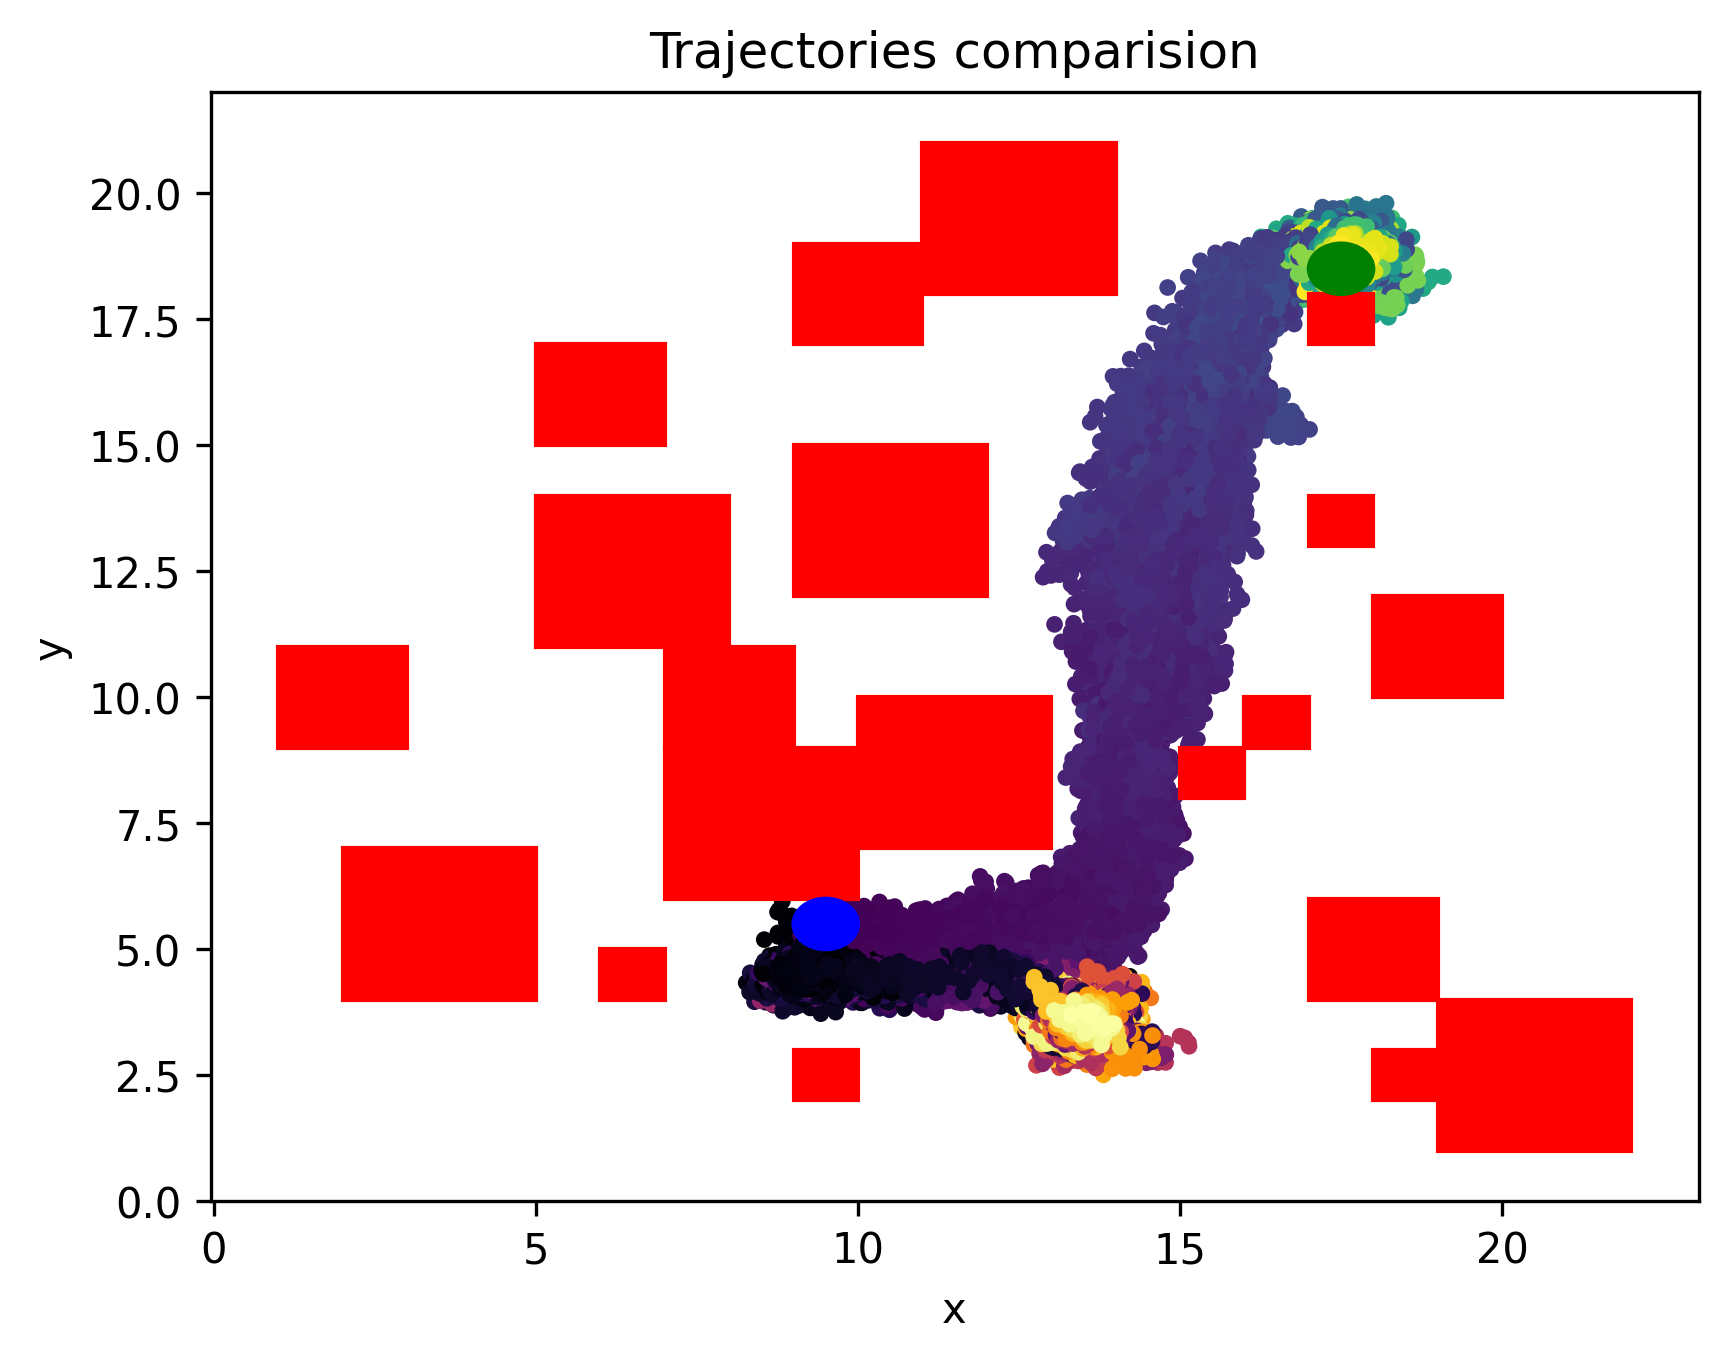

In [134]:
fig1 = compare_2D_trajectories(init_positions, final_positions, goal_position, env.obstacles)

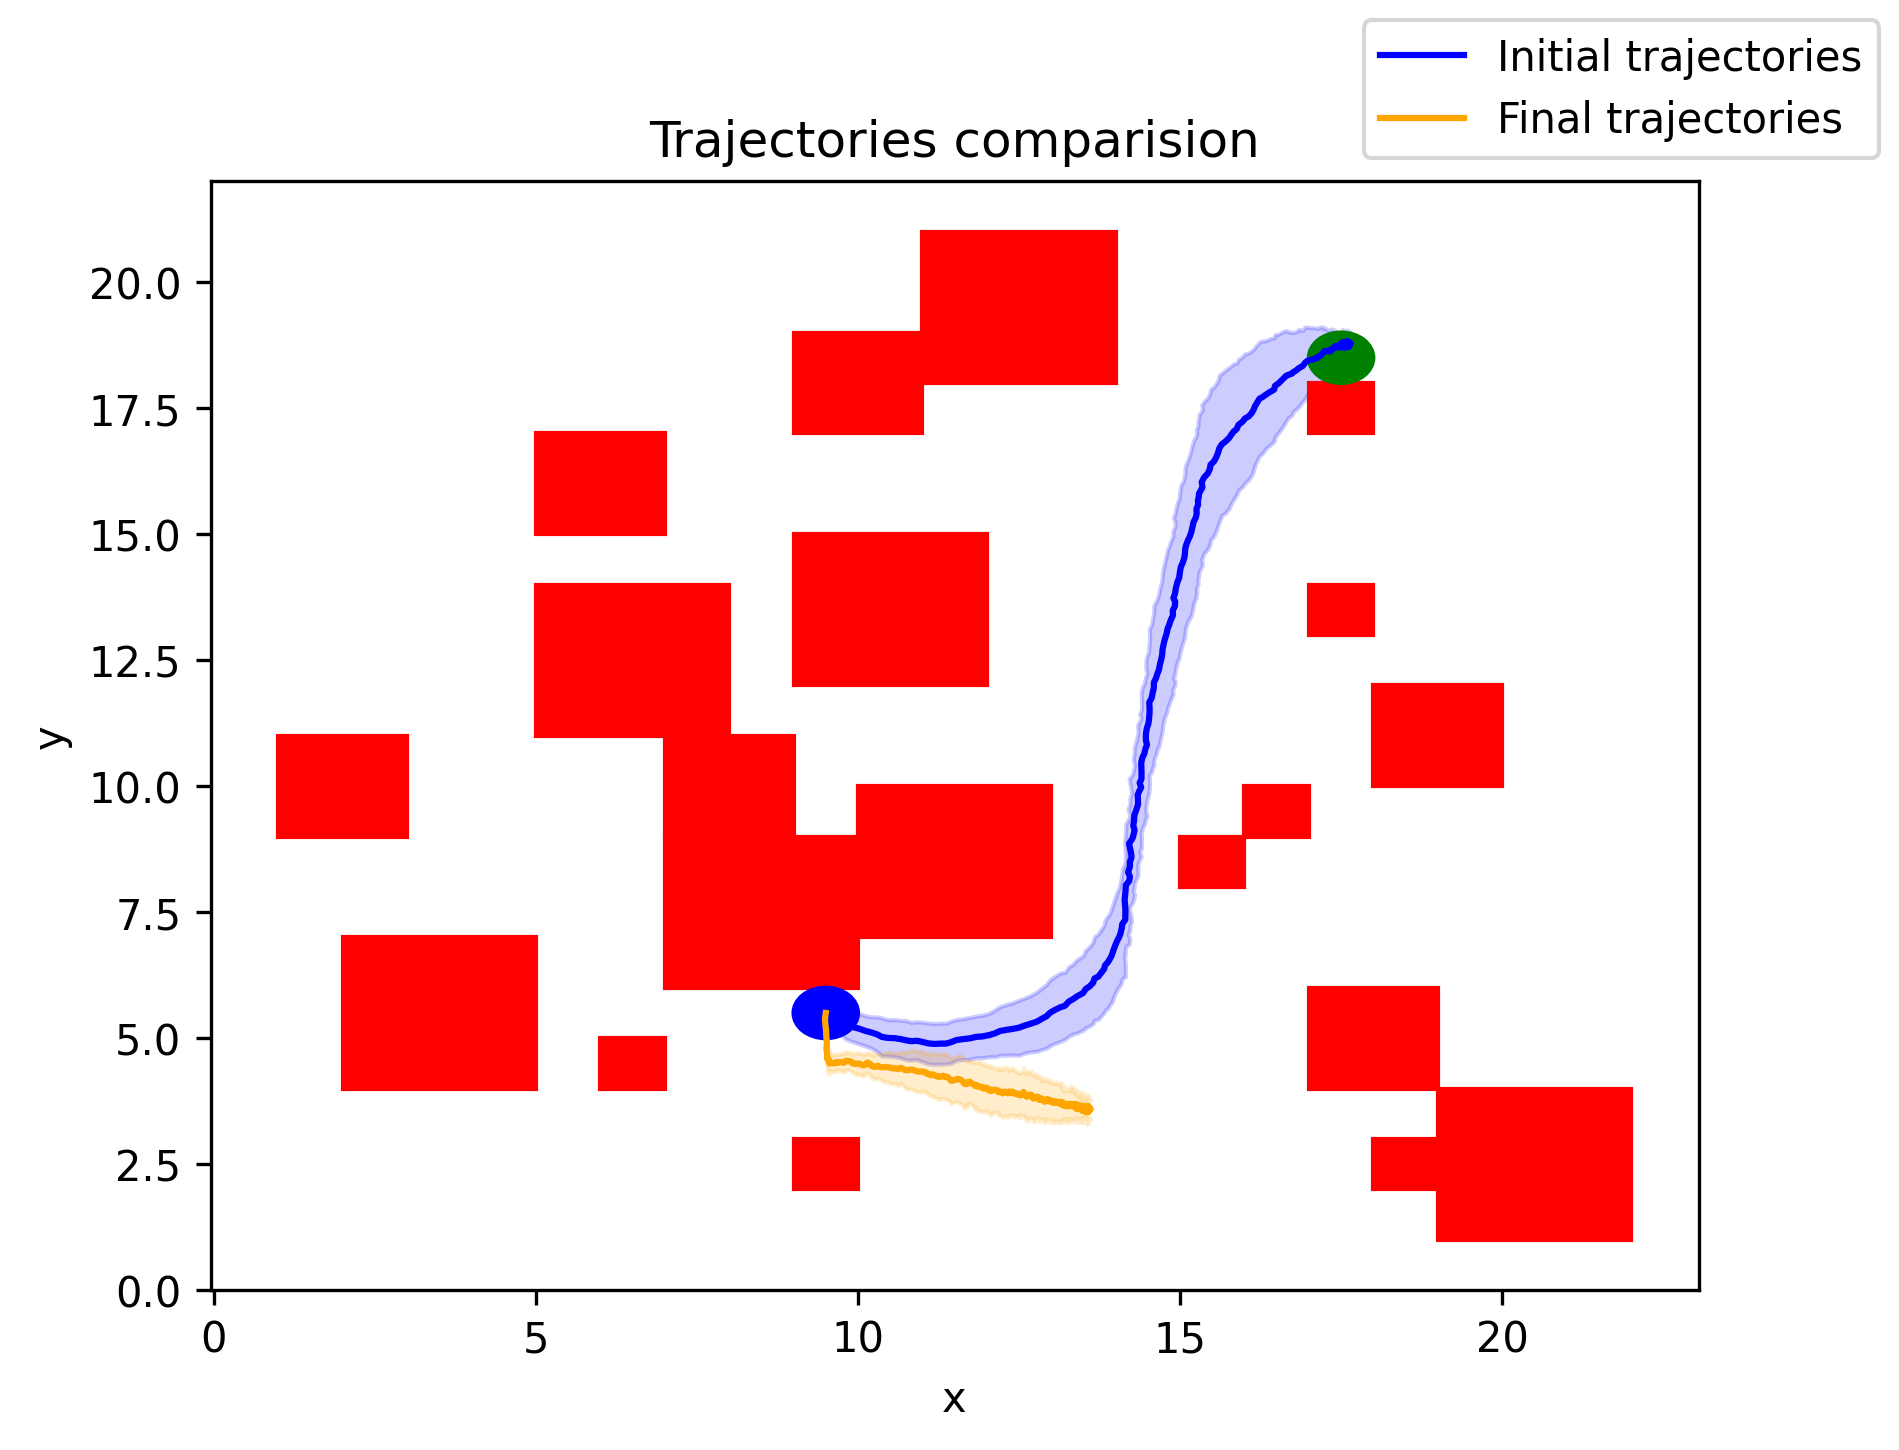

In [133]:
fig2 = compare_2D_trajectories_mean(init_positions, final_positions, goal_position, env.obstacles)

In [175]:
def compare_vector_field(vector_init, vector_final, goal, obstacles, downscale = 1, scale = 1, title="Trajectories comparision"):
    fig, ax = plt.subplots(dpi=300)
    X, Y = vector_init.meshgrid
    init_values = vector_init.values[::downscale, ::downscale]
    final_values = vector_final.values[::downscale, ::downscale]
    ax.quiver(
        X[::downscale, ::downscale],
        Y[::downscale, ::downscale],
        final_values[:, :, 0],
        final_values[:, :, 1],
        units="xy",
        angles="xy",
        scale=scale,
        color="red",
    )
    ax.quiver(
        X[::downscale, ::downscale],
        Y[::downscale, ::downscale],
        init_values[:, :, 0],
        init_values[:, :, 1],
        units="xy",
        angles="xy",
        scale=scale,
        color="black",
    )
    
    for obs in obstacles:
        ax.add_patch(plt.Rectangle((obs.x, obs.y), obs.width, obs.height, color="red"))
    ax.add_patch(plt.Circle(goal, 0.5, color="green"))
    # ax.add_patch(plt.Circle(mean_init[0], 0.5, color="blue"))
    ax.set(title=title, xlabel="x", ylabel="y")
    return fig

(0.0, 20.0)

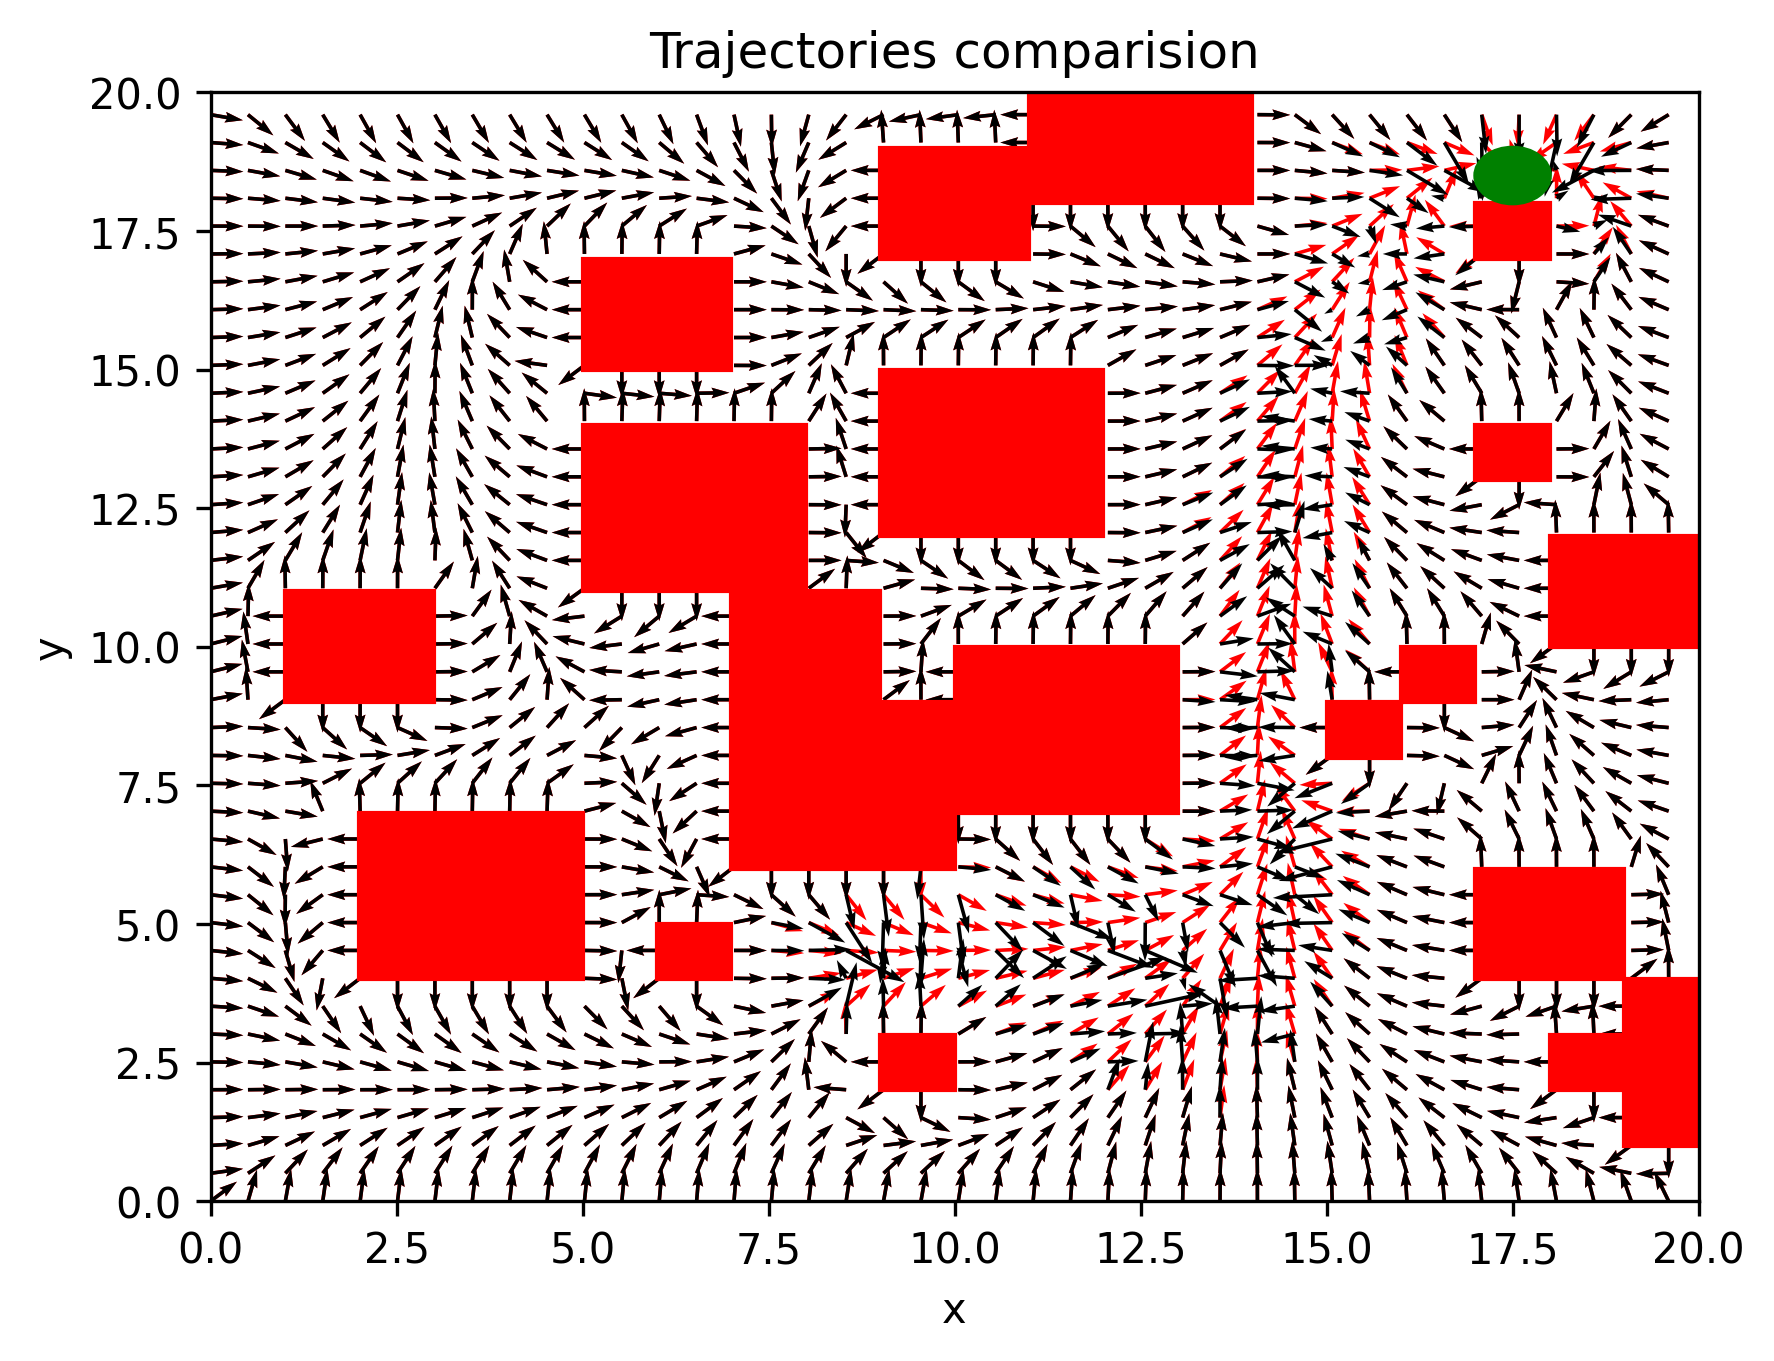

In [179]:
downscale = 5
scale = 2

fig = compare_vector_field(simulation.force_field, final_vector_field, goal_position, env.obstacles, downscale = downscale, scale = scale)
plt.xlim(0, env.width)
plt.ylim(0, env.height)

### 3D case
Finaly we propose a 3D implementation of our method on a test environement to show its adaptation to higher dimentional problems and to focus on the target medical application.

In [ ]:
width, height, depth = 20, 20, 20
nb_obs, obs_size = 40, 3 
seed = 0

env_3d = RandomObstacles3D(width, height, depth, nb_obs=nb_obs, max_size=obs_size, seed=seed)
env_3d.reset()

ti.init(arch=ti.gpu)
converter_3d = Env3DConverter(env_3d)
solver = DiffusionSolver(env_3d)

concentration = solver.solve(init_value=100)
log_concentration = log(concentration)
anim = vis.animate_volume(log_concentration.values, title="Concentration in the volume (log)")

This time all the agents will start from the same position in order to show that our method can sample multiple paths in the environement by simply adding noise to the simulation. We set the number of agents to 10 for visualization purpose, but it can be increased with ease.

In [ ]:
positions = converter_3d.get_agent_position(repeats=10)
goal_position = converter_3d.get_goal_position()

t_max, dt = 100, 0.1
sigma = 0.01

simulation = WalkerSimulationStoch3D(positions, log_concentration, env_3d.obstacles, t_max=t_max, dt=dt, diffusivity=sigma)
simulation.reset()
simulation.run()

In [ ]:
fig = vis.plot_3D_trajectory(simulation.positions, goal_position, obstacles=env_3d.obstacles)
fig.show()

Let's do the same but with a lot mor initial positions

In [ ]:
converter_3d = Env3DConverter(env_3d)
positions = converter_3d.convert_free_positions_to_point_cloud(step=4)
simulation = WalkerSimulationStoch3D(positions, log_concentration, env_3d.obstacles, t_max=t_max, dt=dt, diffusivity=sigma)
simulation.reset()
simulation.run()

In [ ]:
fig = vis.plot_3D_trajectory(simulation.positions, goal_position, obstacles=env_3d.obstacles)
fig.show()

Once again, we can optimize the 3D trajectories sampled from our simulation by using automatic differentiation and gradient descent.

In [ ]:
simulation.optimize(goal_position, max_iter=20, lr=0.1)

In [ ]:
fig = vis.plot_3D_trajectory(simulation.positions, goal_position, obstacles=env_3d.obstacles)
fig.show()

We can see that with path optimization, all paths clamp to a main trajectory, which is something we want to avoid. To conserve the multiple path sampling property, we can think about adding a constraint to the cost function that force variation in the sampled trajectories.

## TODO

Here is a list of things to improve / test in the current phase :
- Add bending constraints & multiple path sampling to the cost function
- Introduce 3D geometries of organs to test the method on real data 
- Allow obstacle penetration by computing a cost associated with penetration instead of reflexive conditions
- Amortize the concentration computation by learning the distribution with Physic Informed Neural Networks (PINN)
- Compare with existing path planning methods
- Consider more complex configuration space